In [13]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import scipy.optimize as optimization

In [14]:
class MarkowitzModel:
    def __init__(self, stocks, start_date, end_date):
        self.stocks = stocks.copy()
        self.start_date = start_date
        self.end_date = end_date
        # self.dataset = None

        # Пусть будет 100% в год (хотим удвоить).  
        # x^365 = 2, x - доходность акций
        # x = 1.00190084
        # Берём логарифм. ln(x) = 0.000824740721
        # Модель заменяет её сложную динамику на линейную модель. То есть берёём вместо x среднюю доходность и делаем вид, что она постоянно такая
        # self.DOHOD = 0.000824740721
        self.DOHOD = 0.015 # 0.0015
    
    def download_data(self, stdate, endate):
        # df = {}
        # for stock in self.stocks:
        #     ticker = yf.Ticker(stock)
        #     df[stock] = ticker.history(start = self.start_date, end = self.end_date, period='1mo')['Close']
        # return pd.DataFrame(df)
        stock_data = yf.download(self.stocks, start = stdate, end = endate, interval='1mo')
        stock_data = stock_data.dropna()
        return stock_data
    
    def show_data(self, data):
        plt.figure(figsize = (18,6))
        plt.grid(True)
        # plt.xlabel('Expected Volatility')
        # plt.ylabel('Expected Return')
        # plt.colorbar(label = 'Sharp Ratio')
        for stock in self.stocks:
            plt.plot(data['Adj Close'][stock])
        plt.legend(self.stocks, loc='right')
        plt.show()
        # data.plot(figsize = (18,5))
        # plt.show()
        

    def calculate_return(self, data):
        # log_return = np.log(data / data.shift(1))
        # return log_return[1:]
        df = {}
        for stock in self.stocks:
            df[stock] = data['Adj Close'][stock].pct_change()
            
        return pd.DataFrame(df)

    def show_statistics(self, returns):
        #annual return using mean
        print(returns.mean())

        #remember covariance is matrix so it will return that
        print(returns.cov())
    
    def show_mean_variance(self, returns, weights):
        portfolio_return = np.sum(returns.mean() * weights)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))
        print("Expected portfolio mean(return):", portfolio_return)
        print("Expected portfolio volatility(standart deviation):", portfolio_volatility)

    def generate_portfolios(self, returns):
        portfolio_means = []
        portfolio_risks = []
        portfolio_weights = []

        for i in range(10000):
            w = np.random.random(len(self.stocks))
            w /= np.sum(w)
            portfolio_weights.append(w)
            # returns.mean() -  среднее по одной акции на протяжении всего времени
            portfolio_means.append(np.sum(returns.mean() * w))
            portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov(), w))))

        return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)
    
    def show_portfolios(self, returns, volatilities):
        plt.figure(figsize = (18,6))
        plt.scatter(volatilities, returns, c = returns / volatilities, marker='o')
        plt.grid(True)
        plt.xlabel('Expected Volatility')
        plt.ylabel('Expected Return')
        plt.colorbar(label = 'Sharp Ratio')
        plt.show()

    def statistics(self, weights, returns):
        portfolio_return = np.sum(returns.mean() * weights)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))
        return np.array([portfolio_return, portfolio_volatility, portfolio_return / portfolio_volatility])

    def min_function_sharp(self, weights, returns):
        return self.statistics(weights, returns)[1]
    
    def optimize_portfolio(self, weights, returns):
        constrains = [
            {
            'type': 'eq',
            'fun': lambda x: np.sum(x) - 1
            },
            {
            'type': 'eq',
            'fun': lambda x, returns: np.sum(returns.mean() * x) - self.DOHOD, # lambda x : np.sum(x) - 1
            'args': (returns,)
            },
        ]
        #the weight can be 1 at most for single stock or weights can have value with in 0 and 1
        bounds = tuple((0, 1) for _ in range(len(self.stocks)))
        return optimization.minimize(
            fun = self.min_function_sharp,
            x0 = weights[0],
            args = returns,
            method = 'SLSQP',
            bounds = bounds,
            constraints = constrains
        )
    
    def print_optimal_portfolio(self, optimum, returns):
        print("Optimal portfolio:", optimum['x'].round(3))
        print("Expected return, volatility and sharp ratio:", self.statistics(optimum['x'].round(3), returns))

    def show_optimal_portfolios(self, opt, rets, portfolio_rets, portfolio_vols):
        plt.figure(figsize = (10,6))
        plt.scatter(
            portfolio_vols,
            portfolio_rets,
            c = portfolio_rets / portfolio_vols,
            marker='o'
        )
        plt.grid(True)
        plt.xlabel('Expected Volatility')
        plt.ylabel('Expected Return')
        plt.colorbar(label = 'Sharp Ratio')
        plt.plot(
            self.statistics(opt['x'], rets)[1],
            self.statistics(opt['x'], rets)[0],
            'g*',
            markersize = 20
        )
        plt.show()

    
    def get_optimal_weights_get_dataset(self, stdate = "", endate = ""):
        if stdate != "" and endate != "":
            self.dataset = self.download_data(stdate, endate)
        elif stdate != "":
            self.dataset = self.download_data(self.start_date, endate)
        else:
            self.dataset = self.download_data(stdate, self.end_date)
    
    # Do all work!
    def get_optimal_weights(self, is_need_graphics = True):
        if is_need_graphics:
            self.show_data(self.dataset)
        log_daily_returns = self.calculate_return(self.dataset)
        # print(log_daily_returns)
        # return
        # return
        #show_statistics(log_daily_returns)

        pweights, means, risks = self.generate_portfolios(log_daily_returns)

        if is_need_graphics:
            self.show_portfolios(means, risks)

        optimum = self.optimize_portfolio(pweights, log_daily_returns)
        self.print_optimal_portfolio(optimum, log_daily_returns)

        if is_need_graphics:
            self.show_optimal_portfolios(optimum, log_daily_returns, means, risks)

        return optimum['x'].round(3)

In [15]:
stocks = ['AAPL', 'WMT', 'TSLA', 'GE', 'AMZN', 'DB']
start_date = '2014-01-01'
end_date = '2024-01-01'

[*********************100%%**********************]  6 of 6 completed


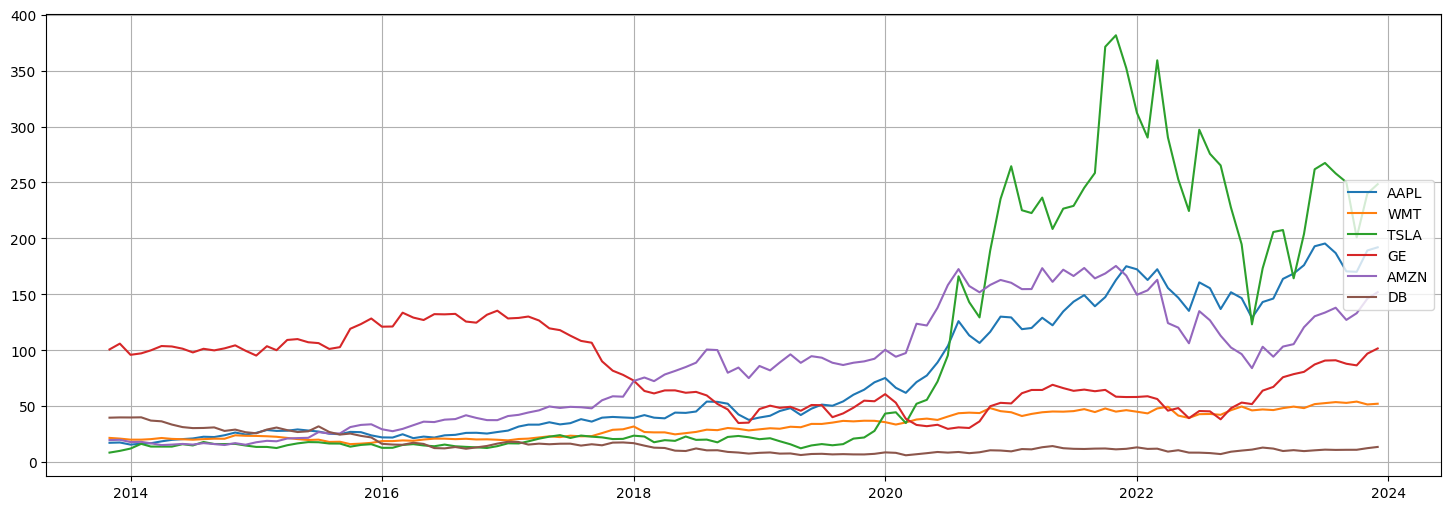

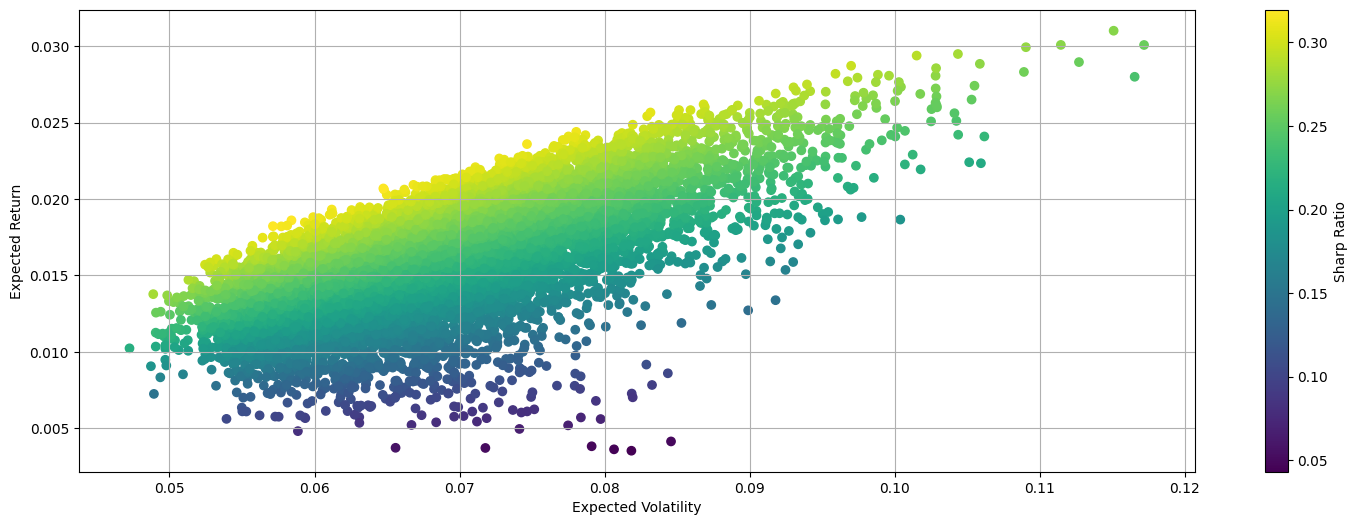

Optimal portfolio: [0.245 0.528 0.03  0.041 0.156 0.   ]
Expected return, volatility and sharp ratio: [0.0150088  0.05019101 0.29903353]


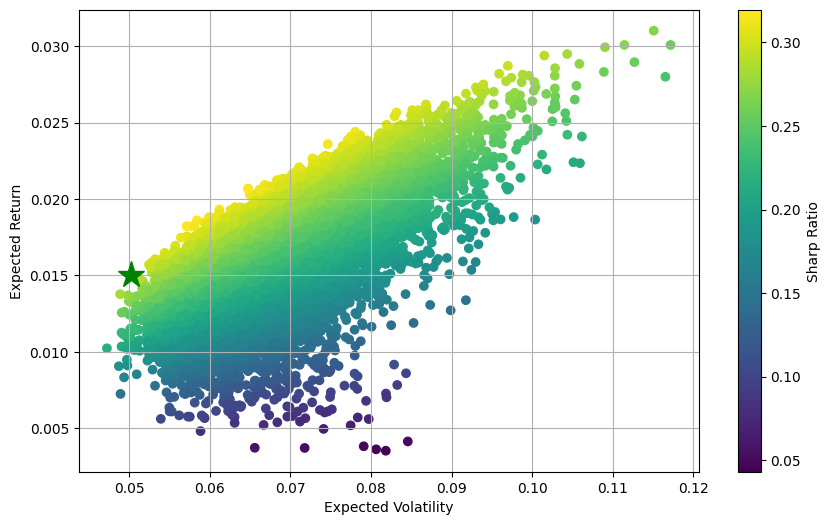

array([0.245, 0.528, 0.03 , 0.041, 0.156, 0.   ])

In [16]:
model = MarkowitzModel(stocks, start_date, end_date)
model.get_optimal_weights_get_dataset('2013-11-01', end_date)
model.get_optimal_weights()

## Попытка в ребалансировку

Смотреть тут: https://readmedium.com/en/https:/python.plainenglish.io/how-to-improve-investment-portfolio-with-rebalancing-strategy-in-python-a58841ee8b5e

In [17]:
stocks = ['AAPL', 'WMT', 'TSLA', 'GE', 'AMZN', 'DB']

In [18]:
stock_data = yf.download(stocks, start='2014-01-01', end='2024-01-01', interval='1mo')
stock_data = stock_data.dropna()

df = {}
for stock in stocks:
    # ticker = yf.Ticker(stock)
    # df[stock] = ticker.history(start = start_date, end = end_date, period='1mo')['Close']
    df[stock] = stock_data['Adj Close'][stock].pct_change()

df = pd.DataFrame(df)
df
# returns = np.log(df / df.shift(1))[1:]
# returns

[*********************100%%**********************]  6 of 6 completed


,AAPL,WMT,TSLA,GE,AMZN,DB
Date,,,,,,
2014-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-01,0.051218,0.000267,0.349485,0.013530,0.009507,0.003321
2014-03-01,0.026058,0.023160,-0.148523,0.027642,-0.071058,-0.072611
2014-04-01,0.099396,0.049643,-0.002687,0.038625,-0.095847,-0.017845
2014-05-01,0.072717,-0.036884,-0.000577,-0.003719,0.027685,-0.079491
...,...,...,...,...,...,...
2023-08-01,-0.043675,0.017203,-0.034962,0.002854,0.032391,-0.021563
2023-09-01,-0.087448,-0.012985,-0.030456,-0.034160,-0.078907,0.009183
2023-10-01,-0.002570,0.021760,-0.197346,-0.016482,0.046963,0.001820


In [19]:
import datetime
from dateutil.relativedelta import relativedelta
import heapq

In [20]:
def portfolio_without_rebalance(stocks, dataset, numStocks, numRev):
    selected_stocks = stocks.copy()
    returns_array = []
    
    # Будем каждый месяц делать ребалансировку. Стартовая дата - 2018-01-01. Конечная дата - 2024-01-01.
    start_month = 1
    start_year = 2014
    end_month = 1
    end_year = 2024
    curr_datetime = datetime.datetime(start_year, start_month + 1, 1)
    next_datetime = curr_datetime + relativedelta(months=1)
    end_datetime = datetime.datetime(end_year, end_month, 1)

    i = 0
    while next_datetime + relativedelta(months=1) < end_datetime:
        next_datetime = curr_datetime + relativedelta(months=1)

        if len(selected_stocks) > 0:
            # Модель Марковица: считаем оптимальные веса для выбранных акций за месяц
            month_model = MarkowitzModel(selected_stocks, curr_datetime.strftime("%Y-%m-%d"), next_datetime.strftime("%Y-%m-%d"))
            month_model.get_optimal_weights_get_dataset((curr_datetime - relativedelta(months=2)).strftime("%Y-%m-%d"), next_datetime.strftime("%Y-%m-%d"))
            weights = month_model.get_optimal_weights(is_need_graphics=False)

            values = np.array(weights * df[selected_stocks].iloc[i,:])
            returns_array.append(np.sum(values))
#             returns_array.append(values.mean())
#             indexes_of_max_value = heapq.nsmallest(numRev, range(len(values)), values.take)

#             # убираем numRev наименее доходных акций
#             selected_stocks = [stocks[ind] for ind in range(len(stocks)) if ind not in indexes_of_max_value]
        
#         current_month_returns = np.array(df.iloc[i,:])
#         # Добавляем ещё наиболее доходных акций в количестве numStocks - numRev.
#         # Сортирую в порядке убывания по доходности за месяц
#         indexes_of_max_value = heapq.nlargest(len(stocks), range(len(current_month_returns)), current_month_returns.take)
        
#         # Хотим добавлять только те акции, которых еще нет в selected_stocks
#         for ind in indexes_of_max_value:
#             if stocks[ind] in selected_stocks:
#                 continue
#             if len(selected_stocks) == numStocks:
#                 break
#             selected_stocks.append(stocks[ind])


#         print("From {} to {} was selected {}\n".format(
#             curr_datetime.strftime("%Y-%m-%d"),
#             next_datetime.strftime("%Y-%m-%d"),
#             selected_stocks
#         ))
#         print("\t", weights)
#         print("\t", df[selected_stocks].iloc[i,:])

        i += 1

#         if i > 5:
#             break
        curr_datetime = next_datetime

    # Рассчитываем для финального месяца: просто запускаем Марковица для вычисления весов
    month_model = MarkowitzModel(selected_stocks, curr_datetime.strftime("%Y-%m-%d"), end_datetime.strftime("%Y-%m-%d"))
    month_model.get_optimal_weights_get_dataset((curr_datetime - relativedelta(months=2)).strftime("%Y-%m-%d"), end_datetime.strftime("%Y-%m-%d"))
    weights = month_model.get_optimal_weights()
    returns = np.array(weights * df[selected_stocks].iloc[i,:])
    # returns_array.append(np.sum(returns))
    returns_array.append(returns.mean())
#     print("-----------------------------------------------------")
#     print("------------------- Final results -------------------")
#     print("Selected stock:", selected_stocks)
#     print("Weights:", weights)
#     print("Returns:", returns)
#     print("-----------------------------------------------------")

    return weights, returns, returns_array

In [21]:
def portfolio(stocks, dataset, numStocks, numRev):
    selected_stocks = stocks.copy()
    returns_array = []
    
    # Будем каждый месяц делать ребалансировку. Стартовая дата - 2018-01-01. Конечная дата - 2024-01-01.
    start_month = 1
    start_year = 2014
    end_month = 1
    end_year = 2024
    curr_datetime = datetime.datetime(start_year, start_month + 1, 1)
    next_datetime = curr_datetime + relativedelta(months=1)
    end_datetime = datetime.datetime(end_year, end_month, 1)

    i = 0
    while next_datetime + relativedelta(months=1) < end_datetime:
        next_datetime = curr_datetime + relativedelta(months=1)

        if len(selected_stocks) > 0:
            # Модель Марковица: считаем оптимальные веса для выбранных акций за месяц
            month_model = MarkowitzModel(selected_stocks, curr_datetime.strftime("%Y-%m-%d"), next_datetime.strftime("%Y-%m-%d"))
            month_model.get_optimal_weights_get_dataset((curr_datetime - relativedelta(months=2)).strftime("%Y-%m-%d"), next_datetime.strftime("%Y-%m-%d"))
            weights = month_model.get_optimal_weights(is_need_graphics=False)

            values = np.array(weights * df[selected_stocks].iloc[i,:])
            returns_array.append(np.sum(values))
#             returns_array.append(values.mean())
            indexes_of_max_value = heapq.nsmallest(numRev, range(len(values)), values.take)

            # убираем numRev наименее доходных акций
            selected_stocks = [stocks[ind] for ind in range(len(stocks)) if ind not in indexes_of_max_value]
        
        current_month_returns = np.array(df.iloc[i,:])
        # Добавляем ещё наиболее доходных акций в количестве numStocks - numRev.
        # Сортирую в порядке убывания по доходности за месяц
        indexes_of_max_value = heapq.nlargest(len(stocks), range(len(current_month_returns)), current_month_returns.take)
        
        # Хотим добавлять только те акции, которых еще нет в selected_stocks
        for ind in indexes_of_max_value:
            if stocks[ind] in selected_stocks:
                continue
            if len(selected_stocks) == numStocks:
                break
            selected_stocks.append(stocks[ind])


        print("From {} to {} was selected {}\n".format(
            curr_datetime.strftime("%Y-%m-%d"),
            next_datetime.strftime("%Y-%m-%d"),
            selected_stocks
        ))
        print("\t", weights)
        print("\t", df[selected_stocks].iloc[i,:])

        i += 1

#         if i > 5:
#             break
        curr_datetime = next_datetime

    # Рассчитываем для финального месяца: просто запускаем Марковица для вычисления весов
    month_model = MarkowitzModel(selected_stocks, curr_datetime.strftime("%Y-%m-%d"), end_datetime.strftime("%Y-%m-%d"))
    month_model.get_optimal_weights_get_dataset((curr_datetime - relativedelta(months=2)).strftime("%Y-%m-%d"), end_datetime.strftime("%Y-%m-%d"))
    weights = month_model.get_optimal_weights()
    returns = np.array(weights * df[selected_stocks].iloc[i,:])
    # returns_array.append(np.sum(returns))
    returns_array.append(returns.mean())
    print("-----------------------------------------------------")
    print("------------------- Final results -------------------")
    print("Selected stock:", selected_stocks)
    print("Weights:", weights)
    print("Returns:", returns)
    print("-----------------------------------------------------")

    return weights, returns, returns_array

[*********************100%%**********************]  6 of 6 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.   0.   0.05 0.   0.   0.95]
Expected return, volatility and sharp ratio: [0.01487239 0.00814128 1.82678814]
From 2014-02-01 to 2014-03-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.   0.   0.05 0.   0.   0.95]
	 TSLA   NaN
GE     NaN
AMZN   NaN
DB     NaN
Name: 2014-01-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************75%%**********            ]  3 of 4 completed

Optimal portfolio: [0.006 0.878 0.078 0.038]
Expected return, volatility and sharp ratio: [1.49606220e-02 1.65373551e-04 9.04656272e+01]
From 2014-03-01 to 2014-04-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.006 0.878 0.078 0.038]
	 AAPL    0.051218
WMT     0.000267
AMZN    0.009507
DB      0.003321
Name: 2014-02-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.    0.821 0.179 0.   ]
Expected return, volatility and sharp ratio: [0.01494761 0.01223729 1.22148021]
From 2014-04-01 to 2014-05-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.    0.821 0.179 0.   ]
	 WMT     0.023160
GE      0.027642
AMZN   -0.071058
DB     -0.072611
Name: 2014-03-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.952 0.048 0.   ]
Expected return, volatility and sharp ratio: [0.01497945 0.02431126 0.61615263]
From 2014-05-01 to 2014-06-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.    0.952 0.048 0.   ]
	 WMT     0.049643
GE      0.038625
AMZN   -0.095847
DB     -0.017845
Name: 2014-04-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.411 0.589 0.   ]
Expected return, volatility and sharp ratio: [1.50008245e-02 3.14582643e-04 4.76848446e+01]
From 2014-06-01 to 2014-07-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.    0.411 0.589 0.   ]
	 TSLA   -0.000577
GE     -0.003719
AMZN    0.027685
DB     -0.079491
Name: 2014-05-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.328 0.    0.672 0.   ]
Expected return, volatility and sharp ratio: [0.01498811 0.08808051 0.17016379]
From 2014-07-01 to 2014-08-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.328 0.    0.672 0.   ]
	 AAPL    0.033402
TSLA    0.155412
AMZN    0.039130
DB     -0.067352
Name: 2014-06-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.435 0.    0.    0.565]
Expected return, volatility and sharp ratio: [0.014997   0.02670093 0.56166591]
From 2014-08-01 to 2014-09-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.435 0.    0.    0.565]
	 AAPL    0.028731
TSLA   -0.069816
AMZN   -0.036302
DB     -0.028994
Name: 2014-07-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.242 0.    0.    0.758]
Expected return, volatility and sharp ratio: [0.01499868 0.00819714 1.82974618]
From 2014-09-01 to 2014-10-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.242 0.    0.    0.758]
	 AAPL    0.072176
GE      0.033002
AMZN    0.083229
DB      0.004391
Name: 2014-08-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.795 0.    0.    0.205]
Expected return, volatility and sharp ratio: [0.01499538 0.0302577  0.49558882]
From 2014-10-01 to 2014-11-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.795 0.    0.    0.205]
	 TSLA   -0.100185
GE     -0.013857
AMZN   -0.048962
DB      0.016030
Name: 2014-09-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed


Optimal portfolio: [0.392 0.608 0.    0.   ]
Expected return, volatility and sharp ratio: [0.01500682 0.007899   1.89983803]
From 2014-11-01 to 2014-12-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.392 0.608 0.    0.   ]
	 WMT    -0.002615
GE      0.018099
AMZN   -0.052661
DB     -0.101549
Name: 2014-10-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.335 0.665 0.    0.   ]
Expected return, volatility and sharp ratio: [0.01502116 0.07353969 0.20425919]
From 2014-12-01 to 2015-01-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.335 0.665 0.    0.   ]
	 AAPL    0.101204
WMT     0.147765
AMZN    0.108623
DB      0.042465
Name: 2014-11-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.348 0.652 0.   ]
Expected return, volatility and sharp ratio: [0.01501272 0.10759304 0.13953246]
From 2015-01-01 to 2015-02-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.    0.348 0.652 0.   ]
	 AAPL   -0.067867
GE     -0.046055
AMZN   -0.083540
DB     -0.080551
Name: 2014-12-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 1. 0. 0.]
Expected return, volatility and sharp ratio: [0.02223566 0.09286714 0.23943515]
From 2015-02-01 to 2015-03-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 1. 0. 0.]
	 TSLA   -0.084574
GE     -0.043431
AMZN    0.142355
DB     -0.034644
Name: 2015-01-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.609 0.    0.    0.391]
Expected return, volatility and sharp ratio: [0.01503654 0.04918778 0.30569669]
From 2015-03-01 to 2015-04-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.609 0.    0.    0.391]
	 TSLA   -0.001277
GE      0.087903
AMZN    0.072293
DB      0.129400
Name: 2015-02-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.099 0.267 0.092 0.543]
Expected return, volatility and sharp ratio: [1.50503706e-02 1.32583572e-04 1.13516104e+02]
From 2015-04-01 to 2015-05-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.099 0.267 0.092 0.543]
	 TSLA   -0.071653
GE     -0.034381
AMZN   -0.021202
DB      0.061106
Name: 2015-03-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.373 0.    0.    0.627]
Expected return, volatility and sharp ratio: [0.01505254 0.01574012 0.9563169 ]
From 2015-05-01 to 2015-06-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.373 0.    0.    0.627]
	 AAPL    0.005786
TSLA    0.197489
AMZN    0.133513
DB     -0.075727
Name: 2015-04-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************75%%**********            ]  3 of 4 completed

Optimal portfolio: [0.302 0.21  0.109 0.379]
Expected return, volatility and sharp ratio: [1.49864091e-02 5.95521934e-06 2.51651673e+03]
From 2015-06-01 to 2015-07-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.302 0.21  0.109 0.379]
	 AAPL    0.040991
WMT    -0.048431
AMZN    0.017663
DB     -0.058878
Name: 2015-05-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.618 0.    0.    0.382]
Expected return, volatility and sharp ratio: [0.01496171 0.03711669 0.4030992 ]
From 2015-07-01 to 2015-08-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.618 0.    0.    0.382]
	 TSLA    0.069617
GE     -0.025669
AMZN    0.011323
DB      0.024182
Name: 2015-06-01 00:00:00, dtype: float64



[                       0%%                      ]

Optimal portfolio: [0.    0.652 0.348 0.   ]
Expected return, volatility and sharp ratio: [0.01502692 0.0878221  0.17110637]
From 2015-08-01 to 2015-09-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.    0.652 0.348 0.   ]
	 TSLA   -0.007866
GE     -0.007197
AMZN    0.235113
DB      0.161141
Name: 2015-07-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 1. 0. 0.]
Expected return, volatility and sharp ratio: [-0.01646311  0.04607344 -0.35732321]
From 2015-09-01 to 2015-10-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 1. 0. 0.]
	 TSLA   -0.064212
GE     -0.049042
AMZN   -0.043383
DB     -0.157624
Name: 2015-08-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.422 0.578 0.    0.   ]
Expected return, volatility and sharp ratio: [0.01499586 0.00961512 1.55961266]
From 2015-10-01 to 2015-11-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.422 0.578 0.    0.   ]
	 WMT     0.008540
GE      0.016116
AMZN   -0.001950
DB     -0.086102
Name: 2015-09-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.487 0.085 0.23  0.197]
Expected return, volatility and sharp ratio: [1.49602369e-02 2.28305465e-05 6.55272835e+02]
From 2015-11-01 to 2015-12-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.487 0.085 0.23  0.197]
	 WMT    -0.117212
TSLA   -0.166948
AMZN    0.222724
DB      0.036721
Name: 2015-10-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.548 0.17  0.022 0.259]
Expected return, volatility and sharp ratio: [1.49299863e-02 2.88157061e-05 5.18119745e+02]
From 2015-12-01 to 2016-01-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.548 0.17  0.022 0.259]
	 AAPL   -0.010042
WMT     0.027953
AMZN    0.062151
DB     -0.080859
Name: 2015-11-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.112 0.662 0.168 0.058]
Expected return, volatility and sharp ratio: [1.50875599e-02 5.43243336e-06 2.77731154e+03]
From 2016-01-01 to 2016-02-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.112 0.662 0.168 0.058]
	 WMT     0.041808
TSLA    0.042343
AMZN    0.016682
DB     -0.059946
Name: 2015-12-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.789 0.211 0.    0.   ]
Expected return, volatility and sharp ratio: [0.0149699  0.02036797 0.73497245]
From 2016-02-01 to 2016-03-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.789 0.211 0.    0.   ]
	 AAPL   -0.075243
GE     -0.057038
AMZN   -0.131515
DB     -0.259213
Name: 2016-01-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.533 0.    0.467]
Expected return, volatility and sharp ratio: [0.01499188 0.04600761 0.32585646]
From 2016-03-01 to 2016-04-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.533 0.    0.467]
	 WMT    -0.000301
TSLA    0.003818
AMZN   -0.058739
DB     -0.039128
Name: 2016-02-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************75%%**********            ]  3 of 4 completed

Optimal portfolio: [0.842 0.    0.    0.158]
Expected return, volatility and sharp ratio: [0.01500058 0.01412759 1.06179333]
From 2016-04-01 to 2016-05-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.842 0.    0.    0.158]
	 AAPL    0.133327
TSLA    0.197155
AMZN    0.074423
DB     -0.014543
Name: 2016-03-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.334 0.222 0.233 0.211]
Expected return, volatility and sharp ratio: [1.49940729e-02 9.03332995e-05 1.65986109e+02]
From 2016-05-01 to 2016-06-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.334 0.222 0.233 0.211]
	 TSLA    0.047830
GE     -0.032715
AMZN    0.111094
DB      0.119244
Name: 2016-04-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.102 0.564 0.334 0.   ]
Expected return, volatility and sharp ratio: [1.50216146e-02 2.40238622e-05 6.25278918e+02]
From 2016-06-01 to 2016-07-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.102 0.564 0.334 0.   ]
	 TSLA   -0.072811
GE     -0.016911
AMZN    0.095817
DB     -0.061181
Name: 2016-05-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************75%%**********            ]  3 of 4 completed

Optimal portfolio: [0.    0.676 0.28  0.044]
Expected return, volatility and sharp ratio: [1.50711097e-02 6.11721314e-05 2.46372153e+02]
From 2016-07-01 to 2016-08-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.    0.676 0.28  0.044]
	 AAPL   -0.036831
WMT     0.039201
AMZN   -0.009920
DB     -0.228652
Name: 2016-06-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.206 0.539 0.027 0.228]
Expected return, volatility and sharp ratio: [1.50119077e-02 2.02169596e-05 7.42540320e+02]
From 2016-08-01 to 2016-09-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.206 0.539 0.027 0.228]
	 AAPL    0.090063
TSLA    0.106039
AMZN    0.060353
DB     -0.021122
Name: 2016-07-01 00:00:00, dtype: float64



[                       0%%                      ]

Optimal portfolio: [0.386 0.173 0.217 0.224]
Expected return, volatility and sharp ratio: [1.50137030e-02 6.75796846e-06 2.22162964e+03]
From 2016-09-01 to 2016-10-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.386 0.173 0.217 0.224]
	 AAPL    0.018136
GE      0.003212
AMZN    0.013640
DB      0.097470
Name: 2016-08-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.307 0.    0.353 0.339]
Expected return, volatility and sharp ratio: [1.49916334e-02 2.16914559e-05 6.91130803e+02]
From 2016-10-01 to 2016-11-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.307 0.    0.353 0.339]
	 AAPL    0.071277
TSLA   -0.037640
AMZN    0.088603
DB     -0.112542
Name: 2016-09-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.    0.189 0.383 0.428]
Expected return, volatility and sharp ratio: [1.49445758e-02 3.57930837e-06 4.17526915e+03]
From 2016-11-01 to 2016-12-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.    0.189 0.383 0.428]
	 AAPL    0.004334
GE     -0.007929
AMZN   -0.056717
DB      0.099313
Name: 2016-10-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.597 0.403 0.   ]
Expected return, volatility and sharp ratio: [1.49779571e-02 1.34240867e-03 1.11575242e+01]
From 2016-12-01 to 2017-01-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.    0.597 0.403 0.   ]
	 WMT     0.005856
GE      0.057045
AMZN   -0.049695
DB      0.097985
Name: 2016-11-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.454 0.176 0.24  0.13 ]
Expected return, volatility and sharp ratio: [1.50533602e-02 1.23096973e-05 1.22288630e+03]
From 2017-01-01 to 2017-02-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.454 0.176 0.24  0.13 ]
	 WMT    -0.018600
GE      0.027308
AMZN   -0.000933
DB      0.145570
Name: 2016-12-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.15  0.433 0.231 0.187]
Expected return, volatility and sharp ratio: [1.50300328e-02 3.91573955e-05 3.83836376e+02]
From 2017-02-01 to 2017-03-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.15  0.433 0.231 0.187]
	 TSLA    0.178951
GE     -0.051247
AMZN    0.098164
DB      0.100000
Name: 2017-01-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
/var/folders/s_/20wwypx94lvg6dgc7vypd2l80000gn/T/ipykernel_21329/1501543472.py:88: RuntimeWarning: invalid value encountered in sqrt
  portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.005 0.267 0.593 0.135]
Expected return, volatility and sharp ratio: [1.49548913e-02 4.16099431e-05 3.59406675e+02]
From 2017-03-01 to 2017-04-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.005 0.267 0.593 0.135]
	 WMT     0.062781
TSLA   -0.007701
AMZN    0.026182
DB     -0.011050
Name: 2017-02-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.    0.    0.628 0.372]
Expected return, volatility and sharp ratio: [0.01500324 0.0451996  0.33193303]
From 2017-04-01 to 2017-05-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.    0.628 0.372]
	 WMT     0.016213
TSLA    0.113245
AMZN    0.049110
DB     -0.128492
Name: 2017-03-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.    0.    0.098 0.902]
Expected return, volatility and sharp ratio: [0.01500492 0.05243732 0.28614961]
From 2017-05-01 to 2017-06-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.    0.    0.098 0.902]
	 TSLA    0.128530
GE     -0.027182
AMZN    0.043371
DB      0.053030
Name: 2017-04-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.33  0.367 0.158 0.145]
Expected return, volatility and sharp ratio: [1.50440947e-02 5.63585982e-05 2.66935218e+02]
From 2017-06-01 to 2017-07-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.33  0.367 0.158 0.145]
	 AAPL    0.063418
TSLA    0.085777
AMZN    0.075276
DB     -0.032651
Name: 2017-05-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.041 0.    0.    0.959]
Expected return, volatility and sharp ratio: [0.01500393 0.01551081 0.96732087]
From 2017-07-01 to 2017-08-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.041 0.    0.    0.959]
	 TSLA    0.060409
GE     -0.013514
AMZN   -0.026764
DB      0.029362
Name: 2017-06-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [0.0065825  0.01958877 0.33603449]
From 2017-08-01 to 2017-09-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA   -0.105473
GE     -0.041789
AMZN    0.020434
DB      0.002811
Name: 2017-07-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.649 0.    0.    0.351]
Expected return, volatility and sharp ratio: [0.01499828 0.01933189 0.77583138]
From 2017-09-01 to 2017-10-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.649 0.    0.    0.351]
	 AAPL    0.102669
TSLA    0.100257
AMZN   -0.007269
DB     -0.103700
Name: 2017-08-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.197 0.167 0.181 0.454]
Expected return, volatility and sharp ratio: [1.49681627e-02 2.77817320e-05 5.38777163e+02]
From 2017-10-01 to 2017-11-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.197 0.167 0.181 0.454]
	 TSLA   -0.041585
GE     -0.015071
AMZN   -0.019631
DB      0.080675
Name: 2017-09-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.356 0.117 0.356 0.171]
Expected return, volatility and sharp ratio: [1.50617143e-02 3.86129867e-05 3.90068618e+02]
From 2017-11-01 to 2017-12-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.356 0.117 0.356 0.171]
	 AAPL    0.096808
TSLA   -0.028056
AMZN    0.149717
DB     -0.058449
Name: 2017-10-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.605 0.    0.395]
Expected return, volatility and sharp ratio: [0.01497454 0.00921633 1.62478406]
From 2017-12-01 to 2018-01-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.    0.605 0.    0.395]
	 TSLA   -0.068410
GE     -0.092758
AMZN    0.064662
DB      0.159189
Name: 2017-11-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.33 0.   0.   0.67]
Expected return, volatility and sharp ratio: [0.01497523 0.0088597  1.69026433]
From 2018-01-01 to 2018-02-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.33 0.   0.   0.67]
	 AAPL   -0.011706
GE     -0.045927
AMZN   -0.006187
DB      0.009014
Name: 2017-12-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.614 0.185 0.148 0.053]
Expected return, volatility and sharp ratio: [1.50276363e-02 7.05809634e-05 2.12913448e+02]
From 2018-02-01 to 2018-03-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.614 0.185 0.148 0.053]
	 TSLA    0.137980
GE     -0.065322
AMZN    0.240639
DB     -0.036259
Name: 2018-01-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [-0.00031015  0.06044238 -0.00513138]
From 2018-03-01 to 2018-04-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA   -0.031752
GE     -0.127397
AMZN    0.042429
DB     -0.130862
Name: 2018-02-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed


Optimal portfolio: [0.    0.301 0.699 0.   ]
Expected return, volatility and sharp ratio: [0.01500096 0.0785506  0.19097191]
From 2018-04-01 to 2018-05-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.    0.301 0.699 0.   ]
	 AAPL   -0.054210
GE     -0.034721
AMZN   -0.043049
DB     -0.122961
Name: 2018-03-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.367 0.228 0.189 0.216]
Expected return, volatility and sharp ratio: [1.50263934e-02 1.21830395e-05 1.23338626e+03]
From 2018-05-01 to 2018-06-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.367 0.228 0.189 0.216]
	 WMT     0.000196
TSLA    0.104347
AMZN    0.082075
DB     -0.022890
Name: 2018-04-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.    0.824 0.176]
Expected return, volatility and sharp ratio: [0.01506855 0.0210798  0.71483335]
From 2018-06-01 to 2018-07-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.    0.824 0.176]
	 WMT    -0.066923
TSLA   -0.031201
AMZN    0.040539
DB     -0.188873
Name: 2018-05-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 1. 0. 0.]
Expected return, volatility and sharp ratio: [0.03690696 0.2369761  0.15574126]
From 2018-07-01 to 2018-08-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0. 1. 0. 0.]
	 WMT     0.044216
GE     -0.033380
AMZN    0.043065
DB     -0.031315
Name: 2018-06-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.685 0.315 0.   ]
Expected return, volatility and sharp ratio: [0.01502921 0.01133013 1.32648129]
From 2018-08-01 to 2018-09-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.685 0.315 0.   ]
	 WMT     0.041798
TSLA   -0.130660
AMZN    0.045676
DB      0.229755
Name: 2018-07-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.   0.   0.62 0.38]
Expected return, volatility and sharp ratio: [0.01503801 0.02072433 0.72562122]
From 2018-09-01 to 2018-10-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.   0.   0.62 0.38]
	 WMT     0.074302
TSLA    0.011807
AMZN    0.132364
DB     -0.137825
Name: 2018-08-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.874 0.    0.    0.126]
Expected return, volatility and sharp ratio: [0.01498075 0.03771396 0.39722036]
From 2018-10-01 to 2018-11-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.874 0.    0.    0.126]
	 TSLA   -0.122290
GE     -0.127512
AMZN   -0.004824
DB      0.008881
Name: 2018-09-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************75%%**********            ]  3 of 4 completed

Optimal portfolio: [0.418 0.003 0.295 0.284]
Expected return, volatility and sharp ratio: [1.48364059e-02 2.79409314e-05 5.30991816e+02]
From 2018-11-01 to 2018-12-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.418 0.003 0.295 0.284]
	 AAPL   -0.030477
WMT     0.067831
AMZN   -0.202192
DB     -0.139965
Name: 2018-10-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [-0.02683897  0.11951622 -0.22456345]
From 2018-12-01 to 2019-01-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA    0.039013
GE     -0.257426
AMZN    0.057672
DB     -0.062436
Name: 2018-11-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.672 0.328 0.    0.   ]
Expected return, volatility and sharp ratio: [0.01504368 0.06488608 0.23184761]
From 2019-01-01 to 2019-02-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.672 0.328 0.    0.   ]
	 WMT    -0.046083
GE      0.009333
AMZN   -0.111350
DB     -0.110262
Name: 2018-12-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [1. 0. 0. 0.]
Expected return, volatility and sharp ratio: [3.36801337e-02 9.96761066e-04 3.37895760e+01]
From 2019-02-01 to 2019-03-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [1. 0. 0. 0.]
	 AAPL    0.055154
GE      0.344454
AMZN    0.144317
DB      0.089571
Name: 2019-01-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.307 0.048 0.307 0.337]
Expected return, volatility and sharp ratio: [1.49564800e-02 5.55848287e-05 2.69074860e+02]
From 2019-03-01 to 2019-04-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.307 0.048 0.307 0.337]
	 AAPL    0.040315
GE      0.063543
AMZN   -0.045906
DB      0.040540
Name: 2019-02-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed


Optimal portfolio: [0.277 0.723 0.    0.   ]
Expected return, volatility and sharp ratio: [0.01499089 0.02071266 0.72375461]
From 2019-04-01 to 2019-05-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.277 0.723 0.    0.   ]
	 AAPL    0.101731
GE     -0.038498
AMZN    0.085936
DB     -0.121212
Name: 2019-03-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [0.00162277 0.1134708  0.01430125]
From 2019-05-01 to 2019-06-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA   -0.147109
GE      0.019369
AMZN    0.081859
DB      0.019704
Name: 2019-04-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.799 0.201 0.   ]
Expected return, volatility and sharp ratio: [0.01499503 0.1246606  0.12028686]
From 2019-06-01 to 2019-07-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.    0.799 0.201 0.   ]
	 AAPL   -0.127573
GE     -0.071780
AMZN   -0.078613
DB     -0.182367
Name: 2019-05-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [0.02630628 0.05725509 0.45945749]
From 2019-07-01 to 2019-08-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA    0.206848
GE      0.112288
AMZN    0.066792
DB      0.146536
Name: 2019-06-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [1. 0. 0. 0.]
Expected return, volatility and sharp ratio: [0.00750008 0.10425929 0.07193682]
From 2019-08-01 to 2019-09-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [1. 0. 0. 0.]
	 AAPL    0.076394
GE     -0.003561
AMZN   -0.014179
DB      0.023591
Name: 2019-07-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.79 0.   0.21 0.  ]
Expected return, volatility and sharp ratio: [0.01498073 0.05813225 0.25770078]
From 2019-09-01 to 2019-10-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.79 0.   0.21 0.  ]
	 WMT     0.035151
GE     -0.210526
AMZN   -0.048474
DB     -0.071703
Name: 2019-08-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.19  0.116 0.471 0.223]
Expected return, volatility and sharp ratio: [1.50127580e-02 9.91125109e-06 1.51471877e+03]
From 2019-10-01 to 2019-11-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.19  0.116 0.471 0.223]
	 AAPL    0.077038
WMT     0.043797
AMZN   -0.022733
DB      0.034483
Name: 2019-09-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.071 0.146 0.616 0.167]
Expected return, volatility and sharp ratio: [1.50048746e-02 8.00533417e-07 1.87435955e+04]
From 2019-11-01 to 2019-12-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.071 0.146 0.616 0.167]
	 AAPL    0.110685
TSLA    0.307427
AMZN    0.023475
DB     -0.033333
Name: 2019-10-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [0.0198545  0.00886315 2.24011645]
From 2019-12-01 to 2020-01-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA    0.047695
GE      0.129259
AMZN    0.013587
DB     -0.005517
Name: 2019-11-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0. 1. 0. 0.]
Expected return, volatility and sharp ratio: [0.05354922 0.08953334 0.59809246]
From 2020-01-01 to 2020-02-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 1. 0. 0.]
	 TSLA    0.267897
GE     -0.009761
AMZN    0.026122
DB      0.079057
Name: 2019-12-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.009 0.    0.991 0.   ]
Expected return, volatility and sharp ratio: [0.01493193 0.10796776 0.13829989]
From 2020-02-01 to 2020-03-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.009 0.    0.991 0.   ]
	 AAPL    0.054010
TSLA    0.555160
AMZN    0.087064
DB      0.176092
Name: 2020-01-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [-0.01359657  0.06875503 -0.1977539 ]
From 2020-03-01 to 2020-04-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 WMT    -0.059482
GE     -0.126104
AMZN   -0.062214
DB     -0.046994
Name: 2020-02-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.816 0.184 0.    0.   ]
Expected return, volatility and sharp ratio: [0.01494263 0.02778918 0.53771409]
From 2020-04-01 to 2020-05-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.816 0.184 0.    0.   ]
	 AAPL   -0.067554
GE     -0.270220
AMZN    0.035021
DB     -0.263762
Name: 2020-03-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.025 0.54  0.183 0.251]
Expected return, volatility and sharp ratio: [1.49134592e-02 1.00087781e-04 1.49003795e+02]
From 2020-05-01 to 2020-06-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.025 0.54  0.183 0.251]
	 TSLA    0.492137
GE     -0.142511
AMZN    0.268900
DB      0.154206
Name: 2020-04-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.    0.907 0.    0.093]
Expected return, volatility and sharp ratio: [0.01502019 0.04705518 0.31920369]
From 2020-06-01 to 2020-07-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.    0.907 0.    0.093]
	 TSLA    0.067939
GE     -0.033824
AMZN   -0.012785
DB      0.133603
Name: 2020-05-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.711 0.289 0.   ]
Expected return, volatility and sharp ratio: [0.0150848  0.07141385 0.21123076]
From 2020-07-01 to 2020-08-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.711 0.289 0.   ]
	 WMT    -0.030252
TSLA    0.293186
AMZN    0.129567
DB      0.133333
Name: 2020-06-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.167 0.    0.    0.833]
Expected return, volatility and sharp ratio: [0.01503679 0.07654348 0.19644764]
From 2020-08-01 to 2020-09-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.167 0.    0.    0.833]
	 AAPL    0.165132
TSLA    0.325011
AMZN    0.147114
DB     -0.063025
Name: 2020-07-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.045 0.955 0.   ]
Expected return, volatility and sharp ratio: [0.01492957 0.14824644 0.1007078 ]
From 2020-09-01 to 2020-10-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.045 0.955 0.   ]
	 WMT     0.073029
TSLA    0.741452
AMZN    0.090461
DB      0.068386
Name: 2020-08-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [1. 0. 0. 0.]
Expected return, volatility and sharp ratio: [0.00174282 0.01418989 0.12282129]
From 2020-10-01 to 2020-11-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [1. 0. 0. 0.]
	 AAPL   -0.100908
GE     -0.017350
AMZN   -0.087579
DB     -0.118573
Name: 2020-09-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.    0.925 0.075]
Expected return, volatility and sharp ratio: [0.0149304  0.05715352 0.26123322]
From 2020-11-01 to 2020-12-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.    0.    0.925 0.075]
	 WMT    -0.008291
GE      0.193479
AMZN   -0.035754
DB      0.101190
Name: 2020-10-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [1. 0. 0. 0.]
Expected return, volatility and sharp ratio: [0.02232055 0.1115373  0.20011731]
From 2020-12-01 to 2021-01-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [1. 0. 0. 0.]
	 AAPL    0.093607
GE      0.371968
AMZN    0.043440
DB      0.202162
Name: 2020-11-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.456 0.544 0.   ]
Expected return, volatility and sharp ratio: [0.01500785 0.03963746 0.37862794]
From 2021-01-01 to 2021-02-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.456 0.544 0.   ]
	 WMT    -0.056548
TSLA    0.243252
AMZN    0.028058
DB     -0.019784
Name: 2020-12-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.04  0.372 0.208 0.38 ]
Expected return, volatility and sharp ratio: [1.50263158e-02 2.22099190e-05 6.76558783e+02]
From 2021-02-01 to 2021-03-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.04  0.372 0.208 0.38 ]
	 AAPL   -0.005502
WMT    -0.021828
AMZN   -0.015576
DB     -0.071560
Name: 2021-01-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.    0.462 0.261 0.278]
Expected return, volatility and sharp ratio: [1.50385454e-02 6.03156920e-05 2.49330562e+02]
From 2021-03-01 to 2021-04-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.    0.462 0.261 0.278]
	 AAPL   -0.081085
GE      0.174157
AMZN   -0.035328
DB      0.212451
Name: 2021-02-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0. 1. 0. 0.]
Expected return, volatility and sharp ratio: [0.02360553 0.03315433 0.71198933]
From 2021-04-01 to 2021-05-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0. 1. 0. 0.]
	 WMT     0.045490
GE      0.047049
AMZN    0.000372
DB     -0.022005
Name: 2021-03-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [1. 0. 0. 0.]
Expected return, volatility and sharp ratio: [0.02474529 0.01356624 1.82403455]
From 2021-05-01 to 2021-06-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [1. 0. 0. 0.]
	 AAPL    0.076218
GE      0.000162
AMZN    0.120663
DB      0.166667
Name: 2021-04-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.435 0.46  0.024 0.081]
Expected return, volatility and sharp ratio: [1.50137635e-02 1.52637734e-04 9.83620696e+01]
From 2021-06-01 to 2021-07-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.435 0.46  0.024 0.081]
	 WMT     0.015153
GE      0.071646
AMZN   -0.070470
DB      0.077857
Name: 2021-05-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.172 0.    0.828 0.   ]
Expected return, volatility and sharp ratio: [0.01499476 0.05688351 0.26360466]
From 2021-07-01 to 2021-08-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.172 0.    0.828 0.   ]
	 TSLA    0.087137
GE     -0.042674
AMZN    0.067355
DB     -0.133201
Name: 2021-06-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************75%%**********            ]  3 of 4 completed

Optimal portfolio: [0.626 0.    0.    0.374]
Expected return, volatility and sharp ratio: [0.01501246 0.03451124 0.43500194]
From 2021-08-01 to 2021-09-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.626 0.    0.    0.374]
	 AAPL    0.064983
TSLA    0.011034
AMZN   -0.032722
DB     -0.043578
Name: 2021-07-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.185 0.221 0.594]
Expected return, volatility and sharp ratio: [1.49898484e-02 2.04224272e-05 7.33989563e+02]
From 2021-09-01 to 2021-10-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.185 0.221 0.594]
	 WMT     0.038934
TSLA    0.070605
AMZN    0.043034
DB     -0.012790
Name: 2021-08-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.061 0.    0.1   0.838]
Expected return, volatility and sharp ratio: [1.49945696e-02 3.13456106e-05 4.78362658e+02]
From 2021-10-01 to 2021-11-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.061 0.    0.1   0.838]
	 WMT    -0.055416
GE     -0.022579
AMZN   -0.053518
DB      0.028340
Name: 2021-09-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.    0.694 0.306]
Expected return, volatility and sharp ratio: [0.01498268 0.00900963 1.66296346]
From 2021-11-01 to 2021-12-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.    0.    0.694 0.306]
	 TSLA    0.436530
GE      0.018851
AMZN    0.026602
DB      0.009449
Name: 2021-10-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [-0.00466413  0.06305672 -0.07396727]
From 2021-12-01 to 2022-01-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA    0.027612
GE     -0.094212
AMZN    0.039924
DB     -0.062402
Name: 2021-11-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.253 0.27  0.477]
Expected return, volatility and sharp ratio: [0.014974   0.01500309 0.99806059]
From 2022-01-01 to 2022-02-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.    0.253 0.27  0.477]
	 AAPL    0.075796
GE     -0.005474
AMZN   -0.049252
DB      0.039933
Name: 2021-12-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 1. 0. 0.]
Expected return, volatility and sharp ratio: [0.00605256 0.00685775 0.88258733]
From 2022-02-01 to 2022-03-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0. 1. 0. 0.]
	 WMT    -0.029837
GE      0.001203
AMZN   -0.102830
DB      0.111200
Name: 2022-01-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************75%%**********            ]  3 of 4 completed

Optimal portfolio: [0.069 0.476 0.454 0.   ]
Expected return, volatility and sharp ratio: [1.49679274e-02 5.05505481e-05 2.96098221e+02]
From 2022-03-01 to 2022-04-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.069 0.476 0.454 0.   ]
	 WMT    -0.033259
TSLA   -0.070768
AMZN    0.026673
DB     -0.105111
Name: 2022-02-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.692 0.    0.    0.308]
Expected return, volatility and sharp ratio: [0.01505954 0.08604212 0.17502515]
From 2022-04-01 to 2022-05-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.692 0.    0.    0.308]
	 AAPL    0.058821
GE     -0.041985
AMZN    0.061437
DB      0.017699
Name: 2022-03-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0. 0. 0. 1.]
Expected return, volatility and sharp ratio: [-0.04369668  0.24787719 -0.17628358]
From 2022-05-01 to 2022-06-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0. 0. 0. 1.]
	 WMT     0.031303
TSLA   -0.191945
AMZN   -0.237525
DB     -0.218972
Name: 2022-04-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 0. 0. 1.]
Expected return, volatility and sharp ratio: [-0.03495355  0.23551254 -0.1484148 ]
From 2022-06-01 to 2022-07-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 0. 1.]
	 TSLA   -0.129197
GE      0.050168
AMZN   -0.032764
DB      0.131579
Name: 2022-05-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************75%%**********            ]  3 of 4 completed

Optimal portfolio: [0.    0.    0.654 0.346]
Expected return, volatility and sharp ratio: [0.01495183 0.22744843 0.06573721]
From 2022-07-01 to 2022-08-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.    0.    0.654 0.346]
	 AAPL   -0.080080
WMT    -0.051373
AMZN   -0.116459
DB     -0.201486
Name: 2022-06-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.   0.57 0.   0.43]
Expected return, volatility and sharp ratio: [0.01501056 0.04610283 0.32558874]
From 2022-08-01 to 2022-09-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.   0.57 0.   0.43]
	 WMT     0.086116
TSLA    0.323765
AMZN    0.270596
DB     -0.003432
Name: 2022-07-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [1. 0. 0. 0.]
Expected return, volatility and sharp ratio: [-0.00672655  0.01486763 -0.45242889]
From 2022-09-01 to 2022-10-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [1. 0. 0. 0.]
	 AAPL   -0.032552
GE     -0.006359
AMZN   -0.060615
DB     -0.045924
Name: 2022-08-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************75%%**********            ]  3 of 4 completed

Optimal portfolio: [0.    0.    0.401 0.599]
Expected return, volatility and sharp ratio: [0.01491812 0.17546148 0.08502221]
From 2022-10-01 to 2022-11-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.    0.    0.401 0.599]
	 AAPL   -0.119756
WMT    -0.017240
AMZN   -0.108622
DB     -0.109507
Name: 2022-09-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.559 0.436 0.005]
Expected return, volatility and sharp ratio: [1.51139991e-02 6.90203049e-05 2.18979025e+02]
From 2022-11-01 to 2022-12-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.    0.559 0.436 0.005]
	 WMT     0.097379
GE      0.258779
AMZN   -0.093451
DB      0.294594
Name: 2022-10-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.    0.429 0.571]
Expected return, volatility and sharp ratio: [0.01497896 0.03238047 0.46259231]
From 2022-12-01 to 2023-01-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.    0.    0.429 0.571]
	 WMT     0.070892
GE      0.104871
AMZN   -0.057595
DB      0.109603
Name: 2022-11-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.726 0.    0.    0.274]
Expected return, volatility and sharp ratio: [0.01498753 0.06035738 0.24831309]
From 2023-01-01 to 2023-02-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.726 0.    0.    0.274]
	 TSLA   -0.367334
GE     -0.025358
AMZN   -0.129894
DB      0.083725
Name: 2022-12-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 0. 0. 1.]
Expected return, volatility and sharp ratio: [0.04634946 0.16278842 0.28472211]
From 2023-02-01 to 2023-03-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 0. 1.]
	 TSLA    0.406235
GE      0.231886
AMZN    0.227738
DB      0.161458
Name: 2023-01-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.222 0.259 0.266 0.253]
Expected return, volatility and sharp ratio: [1.49872665e-02 1.22326742e-04 1.22518317e+02]
From 2023-03-01 to 2023-04-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.222 0.259 0.266 0.253]
	 AAPL    0.021623
WMT    -0.012094
AMZN   -0.086299
DB     -0.068759
Name: 2023-02-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.    0.788 0.    0.212]
Expected return, volatility and sharp ratio: [0.01497109 0.03359933 0.44557706]
From 2023-04-01 to 2023-05-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.788 0.    0.212]
	 WMT     0.037431
TSLA    0.008507
AMZN    0.096148
DB     -0.180578
Name: 2023-03-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.086 0.176 0.152 0.586]
Expected return, volatility and sharp ratio: [1.49882903e-02 1.22403788e-04 1.22449562e+02]
From 2023-05-01 to 2023-06-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.086 0.176 0.152 0.586]
	 TSLA   -0.207992
GE      0.036454
AMZN    0.020912
DB      0.078355
Name: 2023-04-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.    0.162 0.838]
Expected return, volatility and sharp ratio: [0.01502337 0.08309728 0.18079257]
From 2023-06-01 to 2023-07-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.    0.162 0.838]
	 WMT    -0.027158
TSLA    0.241130
AMZN    0.143480
DB     -0.079927
Name: 2023-05-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [1. 0. 0. 0.]
Expected return, volatility and sharp ratio: [0.0456571  0.0404557  1.12857032]
From 2023-07-01 to 2023-08-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [1. 0. 0. 0.]
	 AAPL    0.095844
GE      0.081946
AMZN    0.081108
DB      0.072366
Name: 2023-06-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.314 0.    0.686 0.   ]
Expected return, volatility and sharp ratio: [0.01499582 0.00917788 1.63390808]
From 2023-08-01 to 2023-09-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.314 0.    0.686 0.   ]
	 AAPL    0.012785
TSLA    0.021622
AMZN    0.025468
DB      0.056980
Name: 2023-07-01 00:00:00, dtype: float64



[                       0%%                      ]

Optimal portfolio: [0. 0. 0. 1.]
Expected return, volatility and sharp ratio: [-0.00619032  0.02174071 -0.284734  ]
From 2023-09-01 to 2023-10-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0. 0. 0. 1.]
	 WMT     0.017203
TSLA   -0.034962
AMZN    0.032391
DB     -0.021563
Name: 2023-08-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 0. 0. 1.]
Expected return, volatility and sharp ratio: [0.00550128 0.00520629 1.05666049]
From 2023-10-01 to 2023-11-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 0. 1.]
	 TSLA   -0.030456
GE     -0.034160
AMZN   -0.078907
DB      0.009183
Name: 2023-09-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.7 0.3 0.  0. ]
Expected return, volatility and sharp ratio: [0.01502495 0.22360392 0.06719447]
From 2023-11-01 to 2023-12-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.7 0.3 0.  0. ]
	 TSLA   -0.197346
GE     -0.016482
AMZN    0.046963
DB      0.001820
Name: 2023-10-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed


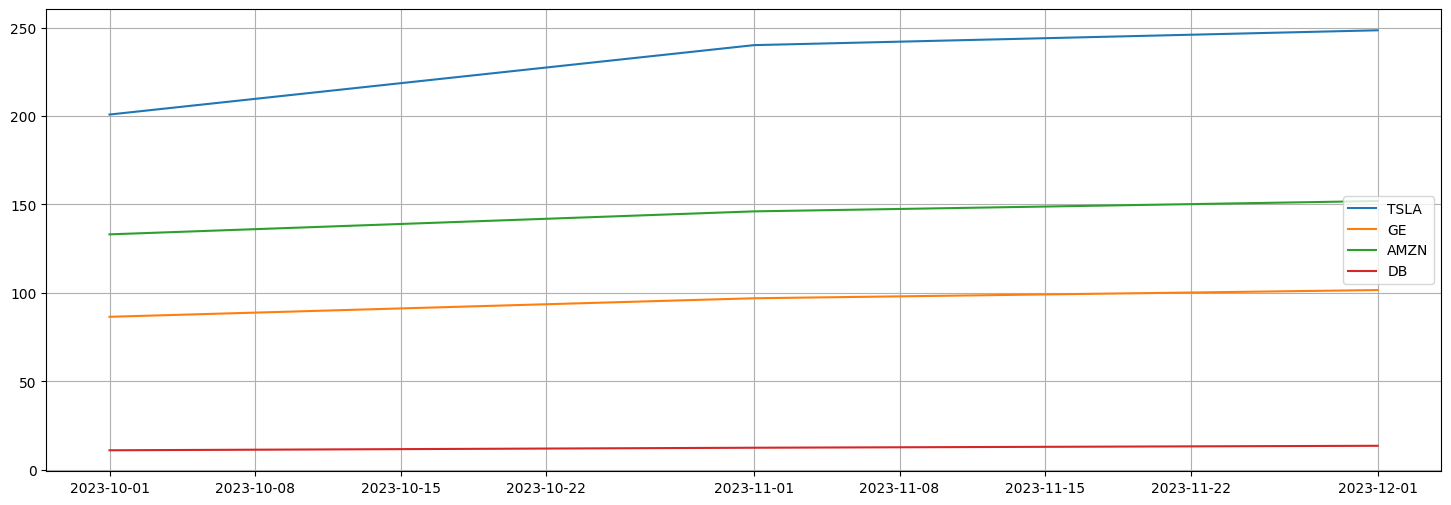

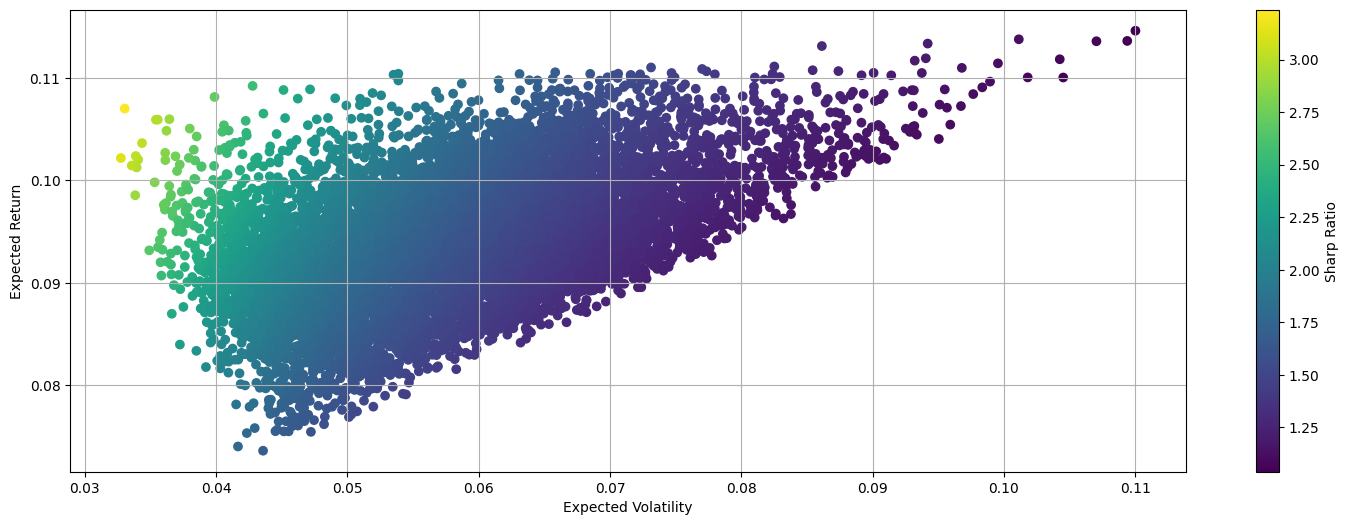

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [0.06886106 0.04075369 1.68968913]


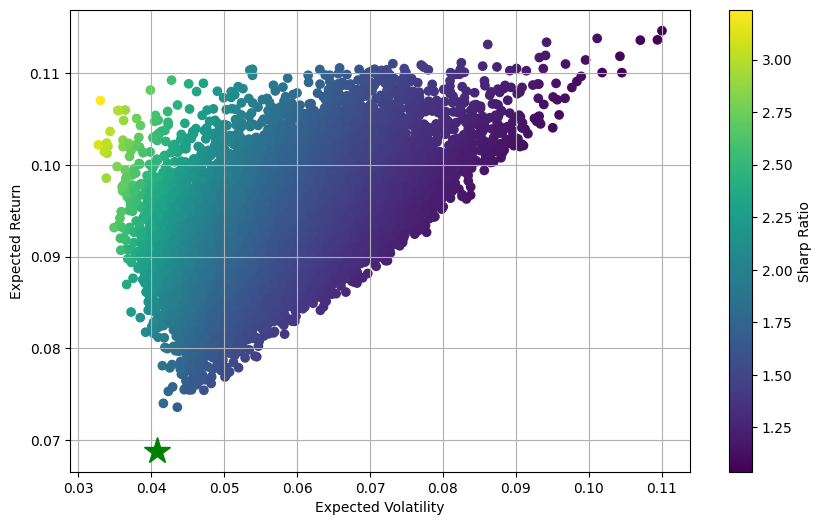

-----------------------------------------------------
------------------- Final results -------------------
Selected stock: ['TSLA', 'GE', 'AMZN', 'DB']
Weights: [0. 0. 1. 0.]
Returns: [0.         0.         0.09767827 0.        ]
-----------------------------------------------------


In [22]:
# print(stocks)
_, _, not_rebalance_returns = portfolio(stocks, df, 4, 2)
not_rebalance_returns = np.array(not_rebalance_returns[1:])

[*********************100%%**********************]  6 of 6 completed
[                       0%%                      ]

Optimal portfolio: [0.   0.   0.05 0.   0.   0.95]
Expected return, volatility and sharp ratio: [0.0148723  0.00814115 1.82680581]
From 2014-02-01 to 2014-03-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.   0.   0.05 0.   0.   0.95]
	 TSLA   NaN
GE     NaN
AMZN   NaN
DB     NaN
Name: 2014-01-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************75%%**********            ]  3 of 4 completed

Optimal portfolio: [0.006 0.876 0.118 0.   ]
Expected return, volatility and sharp ratio: [1.50049014e-02 9.27561239e-05 1.61767232e+02]
From 2014-03-01 to 2014-04-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.006 0.876 0.118 0.   ]
	 AAPL    0.051218
WMT     0.000267
AMZN    0.009507
DB      0.003321
Name: 2014-02-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.    0.821 0.179 0.   ]
Expected return, volatility and sharp ratio: [0.01494762 0.01223741 1.22146939]
From 2014-04-01 to 2014-05-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.    0.821 0.179 0.   ]
	 WMT     0.023160
GE      0.027642
AMZN   -0.071058
DB     -0.072611
Name: 2014-03-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.952 0.048 0.   ]
Expected return, volatility and sharp ratio: [0.01497952 0.02431136 0.61615303]
From 2014-05-01 to 2014-06-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.    0.952 0.048 0.   ]
	 WMT     0.049643
GE      0.038625
AMZN   -0.095847
DB     -0.017845
Name: 2014-04-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.411 0.589 0.   ]
Expected return, volatility and sharp ratio: [1.50007785e-02 3.14603117e-04 4.76815953e+01]
From 2014-06-01 to 2014-07-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.    0.411 0.589 0.   ]
	 TSLA   -0.000577
GE     -0.003719
AMZN    0.027685
DB     -0.079491
Name: 2014-05-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.328 0.    0.672 0.   ]
Expected return, volatility and sharp ratio: [0.01498811 0.08808051 0.17016379]
From 2014-07-01 to 2014-08-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.328 0.    0.672 0.   ]
	 AAPL    0.033402
TSLA    0.155412
AMZN    0.039130
DB     -0.067352
Name: 2014-06-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.435 0.    0.    0.565]
Expected return, volatility and sharp ratio: [0.01499712 0.02670071 0.56167498]
From 2014-08-01 to 2014-09-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.435 0.    0.    0.565]
	 AAPL    0.028731
TSLA   -0.069816
AMZN   -0.036302
DB     -0.028994
Name: 2014-07-01 00:00:00, dtype: float64


Optimal portfolio: [0.242 0.    0.    0.758]
Expected return, volatility and sharp ratio: [0.01499872 0.00819711 1.82975609]
From 2014-09-01 to 2014-10-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.242 0.    0.    0.758]
	 AAPL    0.072176
GE      0.033002
AMZN    0.083229
DB      0.004391
Name: 2014-08-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************75%%**********            ]  3 of 4 completed

Optimal portfolio: [0.795 0.    0.    0.205]
Expected return, volatility and sharp ratio: [0.01499528 0.03025775 0.49558477]
From 2014-10-01 to 2014-11-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.795 0.    0.    0.205]
	 TSLA   -0.100185
GE     -0.013857
AMZN   -0.048962
DB      0.016030
Name: 2014-09-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.392 0.608 0.    0.   ]
Expected return, volatility and sharp ratio: [0.01500689 0.00789923 1.89979181]
From 2014-11-01 to 2014-12-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.392 0.608 0.    0.   ]
	 WMT    -0.002615
GE      0.018099
AMZN   -0.052661
DB     -0.101549
Name: 2014-10-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.335 0.665 0.    0.   ]
Expected return, volatility and sharp ratio: [0.01502119 0.07353922 0.20426095]
From 2014-12-01 to 2015-01-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.335 0.665 0.    0.   ]
	 AAPL    0.101204
WMT     0.147765
AMZN    0.108623
DB      0.042465
Name: 2014-11-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.348 0.652 0.   ]
Expected return, volatility and sharp ratio: [0.01501272 0.10759308 0.13953241]
From 2015-01-01 to 2015-02-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.    0.348 0.652 0.   ]
	 AAPL   -0.067867
GE     -0.046055
AMZN   -0.083540
DB     -0.080551
Name: 2014-12-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0. 1. 0. 0.]
Expected return, volatility and sharp ratio: [0.02223585 0.09286712 0.2394373 ]
From 2015-02-01 to 2015-03-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 1. 0. 0.]
	 TSLA   -0.084574
GE     -0.043431
AMZN    0.142355
DB     -0.034644
Name: 2015-01-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed


Optimal portfolio: [0.609 0.    0.    0.391]
Expected return, volatility and sharp ratio: [0.01503654 0.0491877  0.3056971 ]
From 2015-03-01 to 2015-04-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.609 0.    0.    0.391]
	 TSLA   -0.001277
GE      0.087903
AMZN    0.072293
DB      0.129400
Name: 2015-02-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed


Optimal portfolio: [0.027 0.327 0.136 0.509]
Expected return, volatility and sharp ratio: [1.49530692e-02 1.26105288e-04 1.18576068e+02]
From 2015-04-01 to 2015-05-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.027 0.327 0.136 0.509]
	 AAPL   -0.027549
GE     -0.034381
AMZN   -0.021202
DB      0.061106
Name: 2015-03-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.564 0.249 0.015 0.172]
Expected return, volatility and sharp ratio: [1.50135126e-02 1.43116987e-05 1.04903778e+03]
From 2015-05-01 to 2015-06-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.564 0.249 0.015 0.172]
	 AAPL    0.005786
WMT    -0.045364
AMZN    0.133513
DB     -0.075727
Name: 2015-04-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [0.01449291 0.00448349 3.23250754]
From 2015-06-01 to 2015-07-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA    0.109489
GE      0.007016
AMZN    0.017663
DB     -0.058878
Name: 2015-05-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.391 0.516 0.093 0.   ]
Expected return, volatility and sharp ratio: [1.50522269e-02 3.40591964e-05 4.41943102e+02]
From 2015-07-01 to 2015-08-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.391 0.516 0.093 0.   ]
	 AAPL   -0.033206
TSLA    0.069617
AMZN    0.011323
DB      0.024182
Name: 2015-06-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.613 0.387 0.   ]
Expected return, volatility and sharp ratio: [0.01500786 0.10063422 0.14913274]
From 2015-08-01 to 2015-09-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.    0.613 0.387 0.   ]
	 TSLA   -0.007866
GE     -0.007197
AMZN    0.235113
DB      0.161141
Name: 2015-07-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed


Optimal portfolio: [0. 1. 0. 0.]
Expected return, volatility and sharp ratio: [-0.01646307  0.04607381 -0.35731937]
From 2015-09-01 to 2015-10-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 1. 0. 0.]
	 TSLA   -0.064212
GE     -0.049042
AMZN   -0.043383
DB     -0.157624
Name: 2015-08-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.422 0.578 0.    0.   ]
Expected return, volatility and sharp ratio: [0.01499582 0.00961512 1.55960796]
From 2015-10-01 to 2015-11-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.422 0.578 0.    0.   ]
	 WMT     0.008540
GE      0.016116
AMZN   -0.001950
DB     -0.086102
Name: 2015-09-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.468 0.287 0.081 0.164]
Expected return, volatility and sharp ratio: [1.49948757e-02 2.48235533e-05 6.04058392e+02]
From 2015-11-01 to 2015-12-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.468 0.287 0.081 0.164]
	 WMT    -0.117212
TSLA   -0.166948
AMZN    0.222724
DB      0.036721
Name: 2015-10-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed


Optimal portfolio: [0.543 0.003 0.253 0.201]
Expected return, volatility and sharp ratio: [1.49941427e-02 8.71168469e-06 1.72115305e+03]
From 2015-12-01 to 2016-01-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.543 0.003 0.253 0.201]
	 AAPL   -0.010042
TSLA    0.112743
AMZN    0.062151
DB     -0.080859
Name: 2015-11-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [-0.05741691  0.10479113 -0.54791764]
From 2016-01-01 to 2016-02-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA    0.042343
GE      0.040414
AMZN    0.016682
DB     -0.059946
Name: 2015-12-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 1. 0. 0.]
Expected return, volatility and sharp ratio: [-0.02783219  0.04130464 -0.67382708]
From 2016-02-01 to 2016-03-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 1. 0. 0.]
	 TSLA   -0.203367
GE     -0.057038
AMZN   -0.131515
DB     -0.259213
Name: 2016-01-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.533 0.    0.467]
Expected return, volatility and sharp ratio: [0.01499187 0.04600699 0.32586065]
From 2016-03-01 to 2016-04-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.533 0.    0.467]
	 WMT    -0.000301
TSLA    0.003818
AMZN   -0.058739
DB     -0.039128
Name: 2016-02-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.842 0.    0.    0.158]
Expected return, volatility and sharp ratio: [0.01500058 0.01412784 1.06177475]
From 2016-04-01 to 2016-05-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.842 0.    0.    0.158]
	 AAPL    0.133327
TSLA    0.197155
AMZN    0.074423
DB     -0.014543
Name: 2016-03-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.304 0.326 0.264 0.105]
Expected return, volatility and sharp ratio: [1.49443676e-02 5.38507207e-05 2.77514719e+02]
From 2016-05-01 to 2016-06-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.304 0.326 0.264 0.105]
	 WMT    -0.016425
TSLA    0.047830
AMZN    0.111094
DB      0.119244
Name: 2016-04-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.692 0.308 0.    0.   ]
Expected return, volatility and sharp ratio: [0.01502759 0.00425526 3.53153567]
From 2016-06-01 to 2016-07-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.692 0.308 0.    0.   ]
	 AAPL    0.065287
GE     -0.016911
AMZN    0.095817
DB     -0.061181
Name: 2016-05-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.027 0.689 0.24  0.044]
Expected return, volatility and sharp ratio: [1.50407796e-02 1.85919470e-05 8.08994324e+02]
From 2016-07-01 to 2016-08-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.027 0.689 0.24  0.044]
	 AAPL   -0.036831
WMT     0.039201
AMZN   -0.009920
DB     -0.228652
Name: 2016-06-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.019 0.472 0.299 0.21 ]
Expected return, volatility and sharp ratio: [1.49965200e-02 2.11669919e-06 7.08486123e+03]
From 2016-08-01 to 2016-09-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.019 0.472 0.299 0.21 ]
	 AAPL    0.090063
TSLA    0.106039
AMZN    0.060353
DB     -0.021122
Name: 2016-07-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
/var/folders/s_/20wwypx94lvg6dgc7vypd2l80000gn/T/ipykernel_21329/1501543472.py:88: RuntimeWarning: invalid value encountered in sqrt
  portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))
[                       0%%                      ]

Optimal portfolio: [0.196 0.176 0.39  0.238]
Expected return, volatility and sharp ratio: [1.50559522e-02 8.45408770e-05 1.78090797e+02]
From 2016-09-01 to 2016-10-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.196 0.176 0.39  0.238]
	 TSLA   -0.097023
GE      0.003212
AMZN    0.013640
DB      0.097470
Name: 2016-08-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.    0.958 0.042]
Expected return, volatility and sharp ratio: [0.01499549 0.09214957 0.16272986]
From 2016-10-01 to 2016-11-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.    0.958 0.042]
	 WMT     0.016429
TSLA   -0.037640
AMZN    0.088603
DB     -0.112542
Name: 2016-09-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.111 0.382 0.131 0.377]
Expected return, volatility and sharp ratio: [1.49853069e-02 2.74299307e-06 5.46312239e+03]
From 2016-11-01 to 2016-12-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.111 0.382 0.131 0.377]
	 AAPL    0.004334
GE     -0.007929
AMZN   -0.056717
DB      0.099313
Name: 2016-10-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.597 0.403 0.   ]
Expected return, volatility and sharp ratio: [1.49778494e-02 1.34236552e-03 1.11578025e+01]
From 2016-12-01 to 2017-01-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.    0.597 0.403 0.   ]
	 WMT     0.005856
GE      0.057045
AMZN   -0.049695
DB      0.097985
Name: 2016-11-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.488 0.148 0.225 0.139]
Expected return, volatility and sharp ratio: [1.49803504e-02 1.25457724e-05 1.19405565e+03]
From 2017-01-01 to 2017-02-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.488 0.148 0.225 0.139]
	 WMT    -0.018600
GE      0.027308
AMZN   -0.000933
DB      0.145570
Name: 2016-12-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.289 0.318 0.    0.393]
Expected return, volatility and sharp ratio: [1.50143137e-02 4.99128936e-05 3.00810324e+02]
From 2017-02-01 to 2017-03-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.289 0.318 0.    0.393]
	 TSLA    0.178951
GE     -0.051247
AMZN    0.098164
DB      0.100000
Name: 2017-01-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.284 0.587 0.129]
Expected return, volatility and sharp ratio: [1.49975046e-02 3.53831712e-06 4.23859820e+03]
From 2017-03-01 to 2017-04-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.284 0.587 0.129]
	 WMT     0.062781
TSLA   -0.007701
AMZN    0.026182
DB     -0.011050
Name: 2017-02-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.    0.628 0.372]
Expected return, volatility and sharp ratio: [0.0150032  0.04519959 0.3319322 ]
From 2017-04-01 to 2017-05-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.    0.628 0.372]
	 WMT     0.016213
TSLA    0.113245
AMZN    0.049110
DB     -0.128492
Name: 2017-03-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.    0.    0.098 0.902]
Expected return, volatility and sharp ratio: [0.01500489 0.05243735 0.28614891]
From 2017-05-01 to 2017-06-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.    0.    0.098 0.902]
	 TSLA    0.128530
GE     -0.027182
AMZN    0.043371
DB      0.053030
Name: 2017-04-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.29  0.301 0.187 0.222]
Expected return, volatility and sharp ratio: [1.49757647e-02 1.60213055e-05 9.34740601e+02]
From 2017-06-01 to 2017-07-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.29  0.301 0.187 0.222]
	 AAPL    0.063418
TSLA    0.085777
AMZN    0.075276
DB     -0.032651
Name: 2017-05-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.041 0.    0.    0.959]
Expected return, volatility and sharp ratio: [0.01500401 0.01551095 0.96731726]
From 2017-07-01 to 2017-08-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.041 0.    0.    0.959]
	 TSLA    0.060409
GE     -0.013514
AMZN   -0.026764
DB      0.029362
Name: 2017-06-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [0.0065825  0.01958877 0.33603449]
From 2017-08-01 to 2017-09-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA   -0.105473
GE     -0.041789
AMZN    0.020434
DB      0.002811
Name: 2017-07-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.649 0.    0.    0.351]
Expected return, volatility and sharp ratio: [0.01499829 0.01933193 0.77582985]
From 2017-09-01 to 2017-10-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.649 0.    0.    0.351]
	 AAPL    0.102669
TSLA    0.100257
AMZN   -0.007269
DB     -0.103700
Name: 2017-08-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.234 0.146 0.157 0.463]
Expected return, volatility and sharp ratio: [1.49830535e-02 2.42751429e-05 6.17217934e+02]
From 2017-10-01 to 2017-11-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.234 0.146 0.157 0.463]
	 TSLA   -0.041585
GE     -0.015071
AMZN   -0.019631
DB      0.080675
Name: 2017-09-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.31  0.151 0.378 0.162]
Expected return, volatility and sharp ratio: [1.49599839e-02 8.11922405e-05 1.84253862e+02]
From 2017-11-01 to 2017-12-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.31  0.151 0.378 0.162]
	 AAPL    0.096808
TSLA   -0.028056
AMZN    0.149717
DB     -0.058449
Name: 2017-10-01 00:00:00, dtype: float64



[                       0%%                      ]

Optimal portfolio: [0.    0.605 0.    0.395]
Expected return, volatility and sharp ratio: [0.01497455 0.00921628 1.62479385]
From 2017-12-01 to 2018-01-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.    0.605 0.    0.395]
	 TSLA   -0.068410
GE     -0.092758
AMZN    0.064662
DB      0.159189
Name: 2017-11-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.33 0.   0.   0.67]
Expected return, volatility and sharp ratio: [0.01497527 0.00885975 1.69025862]
From 2018-01-01 to 2018-02-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.33 0.   0.   0.67]
	 AAPL   -0.011706
GE     -0.045927
AMZN   -0.006187
DB      0.009014
Name: 2017-12-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.613 0.195 0.149 0.043]
Expected return, volatility and sharp ratio: [1.50146447e-02 3.33016265e-05 4.50868209e+02]
From 2018-02-01 to 2018-03-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.613 0.195 0.149 0.043]
	 TSLA    0.137980
GE     -0.065322
AMZN    0.240639
DB     -0.036259
Name: 2018-01-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [-0.00031015  0.06044238 -0.00513138]
From 2018-03-01 to 2018-04-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA   -0.031752
GE     -0.127397
AMZN    0.042429
DB     -0.130862
Name: 2018-02-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.    0.301 0.699 0.   ]
Expected return, volatility and sharp ratio: [0.01500096 0.0785507  0.1909717 ]
From 2018-04-01 to 2018-05-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.    0.301 0.699 0.   ]
	 AAPL   -0.054210
GE     -0.034721
AMZN   -0.043049
DB     -0.122961
Name: 2018-03-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.361 0.269 0.163 0.207]
Expected return, volatility and sharp ratio: [1.49499147e-02 5.89258472e-05 2.53707251e+02]
From 2018-05-01 to 2018-06-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.361 0.269 0.163 0.207]
	 WMT     0.000196
TSLA    0.104347
AMZN    0.082075
DB     -0.022890
Name: 2018-04-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.    0.824 0.176]
Expected return, volatility and sharp ratio: [0.01506854 0.02107978 0.71483387]
From 2018-06-01 to 2018-07-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.    0.824 0.176]
	 WMT    -0.066923
TSLA   -0.031201
AMZN    0.040539
DB     -0.188873
Name: 2018-05-01 00:00:00, dtype: float64



[**********************75%%**********            ]  3 of 4 completed

Optimal portfolio: [0. 1. 0. 0.]
Expected return, volatility and sharp ratio: [0.03690696 0.2369761  0.15574126]
From 2018-07-01 to 2018-08-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0. 1. 0. 0.]
	 WMT     0.044216
GE     -0.033380
AMZN    0.043065
DB     -0.031315
Name: 2018-06-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.    0.685 0.315 0.   ]
Expected return, volatility and sharp ratio: [0.01502923 0.01132999 1.32649958]
From 2018-08-01 to 2018-09-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.685 0.315 0.   ]
	 WMT     0.041798
TSLA   -0.130660
AMZN    0.045676
DB      0.229755
Name: 2018-07-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.   0.   0.62 0.38]
Expected return, volatility and sharp ratio: [0.015038   0.02072431 0.72562124]
From 2018-09-01 to 2018-10-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.   0.   0.62 0.38]
	 WMT     0.074302
TSLA    0.011807
AMZN    0.132364
DB     -0.137825
Name: 2018-08-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************75%%**********            ]  3 of 4 completed

Optimal portfolio: [0.874 0.    0.    0.126]
Expected return, volatility and sharp ratio: [0.01498084 0.03771408 0.39722133]
From 2018-10-01 to 2018-11-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.874 0.    0.    0.126]
	 TSLA   -0.122290
GE     -0.127512
AMZN   -0.004824
DB      0.008881
Name: 2018-09-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.418 0.    0.292 0.29 ]
Expected return, volatility and sharp ratio: [1.49741618e-02 9.49399307e-05 1.57722485e+02]
From 2018-11-01 to 2018-12-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.418 0.    0.292 0.29 ]
	 AAPL   -0.030477
WMT     0.067831
AMZN   -0.202192
DB     -0.139965
Name: 2018-10-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [-0.02683897  0.11951622 -0.22456345]
From 2018-12-01 to 2019-01-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA    0.039013
GE     -0.257426
AMZN    0.057672
DB     -0.062436
Name: 2018-11-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.672 0.328 0.    0.   ]
Expected return, volatility and sharp ratio: [0.01504369 0.06488604 0.23184786]
From 2019-01-01 to 2019-02-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.672 0.328 0.    0.   ]
	 WMT    -0.046083
GE      0.009333
AMZN   -0.111350
DB     -0.110262
Name: 2018-12-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [1. 0. 0. 0.]
Expected return, volatility and sharp ratio: [3.36799710e-02 9.97086427e-04 3.37783868e+01]
From 2019-02-01 to 2019-03-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [1. 0. 0. 0.]
	 AAPL    0.055154
GE      0.344454
AMZN    0.144317
DB      0.089571
Name: 2019-01-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.327 0.017 0.299 0.357]
Expected return, volatility and sharp ratio: [1.50218505e-02 1.64484075e-05 9.13270815e+02]
From 2019-03-01 to 2019-04-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.327 0.017 0.299 0.357]
	 AAPL    0.040315
GE      0.063543
AMZN   -0.045906
DB      0.040540
Name: 2019-02-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.277 0.723 0.    0.   ]
Expected return, volatility and sharp ratio: [0.01499097 0.02071271 0.7237571 ]
From 2019-04-01 to 2019-05-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.277 0.723 0.    0.   ]
	 AAPL    0.101731
GE     -0.038498
AMZN    0.085936
DB     -0.121212
Name: 2019-03-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [0.00162277 0.1134708  0.01430125]
From 2019-05-01 to 2019-06-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA   -0.147109
GE      0.019369
AMZN    0.081859
DB      0.019704
Name: 2019-04-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.799 0.201 0.   ]
Expected return, volatility and sharp ratio: [0.0149951  0.12466063 0.12028736]
From 2019-06-01 to 2019-07-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.    0.799 0.201 0.   ]
	 AAPL   -0.127573
GE     -0.071780
AMZN   -0.078613
DB     -0.182367
Name: 2019-05-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [0.02630628 0.05725509 0.45945749]
From 2019-07-01 to 2019-08-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA    0.206848
GE      0.112288
AMZN    0.066792
DB      0.146536
Name: 2019-06-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [1. 0. 0. 0.]
Expected return, volatility and sharp ratio: [0.00750008 0.10425929 0.07193682]
From 2019-08-01 to 2019-09-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [1. 0. 0. 0.]
	 AAPL    0.076394
GE     -0.003561
AMZN   -0.014179
DB      0.023591
Name: 2019-07-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.79 0.   0.21 0.  ]
Expected return, volatility and sharp ratio: [0.01498075 0.05813203 0.25770212]
From 2019-09-01 to 2019-10-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.79 0.   0.21 0.  ]
	 WMT     0.035151
GE     -0.210526
AMZN   -0.048474
DB     -0.071703
Name: 2019-08-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************75%%**********            ]  3 of 4 completed

Optimal portfolio: [0.245 0.107 0.473 0.175]
Expected return, volatility and sharp ratio: [1.49545691e-02 9.26027356e-06 1.61491656e+03]
From 2019-10-01 to 2019-11-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.245 0.107 0.473 0.175]
	 AAPL    0.077038
WMT     0.043797
AMZN   -0.022733
DB      0.034483
Name: 2019-09-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.106 0.068 0.558 0.269]
Expected return, volatility and sharp ratio: [1.50443934e-02 9.56484350e-06 1.57288443e+03]
From 2019-11-01 to 2019-12-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.106 0.068 0.558 0.269]
	 AAPL    0.110685
TSLA    0.307427
AMZN    0.023475
DB     -0.033333
Name: 2019-10-01 00:00:00, dtype: float64



[                       0%%                      ]

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [0.0198545  0.00886315 2.24011645]
From 2019-12-01 to 2020-01-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA    0.047695
GE      0.129259
AMZN    0.013587
DB     -0.005517
Name: 2019-11-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 1. 0. 0.]
Expected return, volatility and sharp ratio: [0.05354932 0.0895333  0.59809394]
From 2020-01-01 to 2020-02-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 1. 0. 0.]
	 TSLA    0.267897
GE     -0.009761
AMZN    0.026122
DB      0.079057
Name: 2019-12-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.009 0.    0.991 0.   ]
Expected return, volatility and sharp ratio: [0.01493193 0.10796776 0.13829989]
From 2020-02-01 to 2020-03-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.009 0.    0.991 0.   ]
	 AAPL    0.054010
TSLA    0.555160
AMZN    0.087064
DB      0.176092
Name: 2020-01-01 00:00:00, dtype: float64



[                       0%%                      ]

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [-0.01359657  0.06875503 -0.1977539 ]
From 2020-03-01 to 2020-04-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 WMT    -0.059482
GE     -0.126104
AMZN   -0.062214
DB     -0.046994
Name: 2020-02-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.816 0.184 0.    0.   ]
Expected return, volatility and sharp ratio: [0.0149426  0.0277892  0.53771256]
From 2020-04-01 to 2020-05-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.816 0.184 0.    0.   ]
	 AAPL   -0.067554
GE     -0.270220
AMZN    0.035021
DB     -0.263762
Name: 2020-03-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.118 0.532 0.161 0.19 ]
Expected return, volatility and sharp ratio: [1.50688932e-02 5.84538402e-05 2.57791330e+02]
From 2020-05-01 to 2020-06-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.118 0.532 0.161 0.19 ]
	 TSLA    0.492137
GE     -0.142511
AMZN    0.268900
DB      0.154206
Name: 2020-04-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.907 0.    0.093]
Expected return, volatility and sharp ratio: [0.01502029 0.04705519 0.31920588]
From 2020-06-01 to 2020-07-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.    0.907 0.    0.093]
	 TSLA    0.067939
GE     -0.033824
AMZN   -0.012785
DB      0.133603
Name: 2020-05-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.711 0.289 0.   ]
Expected return, volatility and sharp ratio: [0.01508474 0.0714138  0.21123003]
From 2020-07-01 to 2020-08-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.711 0.289 0.   ]
	 WMT    -0.030252
TSLA    0.293186
AMZN    0.129567
DB      0.133333
Name: 2020-06-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.167 0.    0.    0.833]
Expected return, volatility and sharp ratio: [0.01503672 0.07654332 0.19644711]
From 2020-08-01 to 2020-09-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.167 0.    0.    0.833]
	 AAPL    0.165132
TSLA    0.325011
AMZN    0.147114
DB     -0.063025
Name: 2020-07-01 00:00:00, dtype: float64


Optimal portfolio: [0.    0.045 0.955 0.   ]
Expected return, volatility and sharp ratio: [0.01492957 0.14824644 0.1007078 ]
From 2020-09-01 to 2020-10-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.045 0.955 0.   ]
	 WMT     0.073029
TSLA    0.741452
AMZN    0.090461
DB      0.068386
Name: 2020-08-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [1. 0. 0. 0.]
Expected return, volatility and sharp ratio: [0.00174274 0.01419026 0.12281216]
From 2020-10-01 to 2020-11-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [1. 0. 0. 0.]
	 AAPL   -0.100908
GE     -0.017350
AMZN   -0.087579
DB     -0.118573
Name: 2020-09-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.    0.925 0.075]
Expected return, volatility and sharp ratio: [0.0149304  0.05715351 0.26123333]
From 2020-11-01 to 2020-12-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.    0.    0.925 0.075]
	 WMT    -0.008291
GE      0.193479
AMZN   -0.035754
DB      0.101190
Name: 2020-10-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [1. 0. 0. 0.]
Expected return, volatility and sharp ratio: [0.0223205  0.11153724 0.20011701]
From 2020-12-01 to 2021-01-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [1. 0. 0. 0.]
	 AAPL    0.093607
GE      0.371968
AMZN    0.043440
DB      0.202162
Name: 2020-11-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.456 0.544 0.   ]
Expected return, volatility and sharp ratio: [0.01500785 0.0396375  0.37862752]
From 2021-01-01 to 2021-02-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.456 0.544 0.   ]
	 WMT    -0.056548
TSLA    0.243252
AMZN    0.028058
DB     -0.019784
Name: 2020-12-01 00:00:00, dtype: float64



[**********************75%%**********            ]  3 of 4 completed

Optimal portfolio: [0.    0.366 0.263 0.371]
Expected return, volatility and sharp ratio: [1.50064400e-02 1.16488878e-04 1.28822942e+02]
From 2021-02-01 to 2021-03-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.    0.366 0.263 0.371]
	 AAPL   -0.005502
WMT    -0.021828
AMZN   -0.015576
DB     -0.071560
Name: 2021-01-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.174 0.444 0.076 0.307]
Expected return, volatility and sharp ratio: [1.50162171e-02 1.00861529e-05 1.48879530e+03]
From 2021-03-01 to 2021-04-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.174 0.444 0.076 0.307]
	 TSLA   -0.148740
GE      0.174157
AMZN   -0.035328
DB      0.212451
Name: 2021-02-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 1. 0. 0.]
Expected return, volatility and sharp ratio: [0.02360556 0.03315455 0.71198572]
From 2021-04-01 to 2021-05-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0. 1. 0. 0.]
	 WMT     0.045490
GE      0.047049
AMZN    0.000372
DB     -0.022005
Name: 2021-03-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [1. 0. 0. 0.]
Expected return, volatility and sharp ratio: [0.02474538 0.01356612 1.82405714]
From 2021-05-01 to 2021-06-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [1. 0. 0. 0.]
	 AAPL    0.076218
GE      0.000162
AMZN    0.120663
DB      0.166667
Name: 2021-04-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
/var/folders/s_/20wwypx94lvg6dgc7vypd2l80000gn/T/ipykernel_21329/1501543472.py:88: RuntimeWarning: invalid value encountered in sqrt
  portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))
[                       0%%                      ]

Optimal portfolio: [0.463 0.44  0.    0.097]
Expected return, volatility and sharp ratio: [1.50029767e-02 7.34969177e-05 2.04130692e+02]
From 2021-06-01 to 2021-07-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.463 0.44  0.    0.097]
	 WMT     0.015153
GE      0.071646
AMZN   -0.070470
DB      0.077857
Name: 2021-05-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.172 0.    0.828 0.   ]
Expected return, volatility and sharp ratio: [0.01499477 0.05688351 0.26360492]
From 2021-07-01 to 2021-08-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.172 0.    0.828 0.   ]
	 TSLA    0.087137
GE     -0.042674
AMZN    0.067355
DB     -0.133201
Name: 2021-06-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.626 0.    0.    0.374]
Expected return, volatility and sharp ratio: [0.01501246 0.03451124 0.43500194]
From 2021-08-01 to 2021-09-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.626 0.    0.    0.374]
	 AAPL    0.064983
TSLA    0.011034
AMZN   -0.032722
DB     -0.043578
Name: 2021-07-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.068 0.193 0.144 0.595]
Expected return, volatility and sharp ratio: [1.50256832e-02 4.05206901e-05 3.70815087e+02]
From 2021-09-01 to 2021-10-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.068 0.193 0.144 0.595]
	 WMT     0.038934
TSLA    0.070605
AMZN    0.043034
DB     -0.012790
Name: 2021-08-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.006 0.165 0.829]
Expected return, volatility and sharp ratio: [1.49146413e-02 1.03215994e-04 1.44499323e+02]
From 2021-10-01 to 2021-11-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.    0.006 0.165 0.829]
	 WMT    -0.055416
GE     -0.022579
AMZN   -0.053518
DB      0.028340
Name: 2021-09-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.    0.694 0.306]
Expected return, volatility and sharp ratio: [0.01498268 0.00900963 1.66296346]
From 2021-11-01 to 2021-12-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.    0.    0.694 0.306]
	 TSLA    0.436530
GE      0.018851
AMZN    0.026602
DB      0.009449
Name: 2021-10-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [-0.00466413  0.06305672 -0.07396727]
From 2021-12-01 to 2022-01-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA    0.027612
GE     -0.094212
AMZN    0.039924
DB     -0.062402
Name: 2021-11-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.325 0.233 0.442]
Expected return, volatility and sharp ratio: [0.01498891 0.01498107 1.00052353]
From 2022-01-01 to 2022-02-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.    0.325 0.233 0.442]
	 AAPL    0.075796
GE     -0.005474
AMZN   -0.049252
DB      0.039933
Name: 2021-12-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 1. 0. 0.]
Expected return, volatility and sharp ratio: [0.00605256 0.00685794 0.88256343]
From 2022-02-01 to 2022-03-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0. 1. 0. 0.]
	 WMT    -0.029837
GE      0.001203
AMZN   -0.102830
DB      0.111200
Name: 2022-01-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.069 0.476 0.454 0.   ]
Expected return, volatility and sharp ratio: [1.49679176e-02 5.06332921e-05 2.95614150e+02]
From 2022-03-01 to 2022-04-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.069 0.476 0.454 0.   ]
	 WMT    -0.033259
TSLA   -0.070768
AMZN    0.026673
DB     -0.105111
Name: 2022-02-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.692 0.    0.    0.308]
Expected return, volatility and sharp ratio: [0.01505954 0.08604208 0.1750253 ]
From 2022-04-01 to 2022-05-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.692 0.    0.    0.308]
	 AAPL    0.058821
GE     -0.041985
AMZN    0.061437
DB      0.017699
Name: 2022-03-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0. 0. 0. 1.]
Expected return, volatility and sharp ratio: [-0.04369665  0.24787715 -0.17628348]
From 2022-05-01 to 2022-06-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0. 0. 0. 1.]
	 WMT     0.031303
TSLA   -0.191945
AMZN   -0.237525
DB     -0.218972
Name: 2022-04-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0. 0. 0. 1.]
Expected return, volatility and sharp ratio: [-0.03495355  0.23551254 -0.1484148 ]
From 2022-06-01 to 2022-07-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 0. 1.]
	 TSLA   -0.129197
GE      0.050168
AMZN   -0.032764
DB      0.131579
Name: 2022-05-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.    0.    0.654 0.346]
Expected return, volatility and sharp ratio: [0.01495183 0.22744843 0.06573721]
From 2022-07-01 to 2022-08-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.    0.    0.654 0.346]
	 AAPL   -0.080080
WMT    -0.051373
AMZN   -0.116459
DB     -0.201486
Name: 2022-06-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.   0.57 0.   0.43]
Expected return, volatility and sharp ratio: [0.01501054 0.04610286 0.32558793]
From 2022-08-01 to 2022-09-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.   0.57 0.   0.43]
	 WMT     0.086116
TSLA    0.323765
AMZN    0.270596
DB     -0.003432
Name: 2022-07-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [1. 0. 0. 0.]
Expected return, volatility and sharp ratio: [-0.00672659  0.0148677  -0.45242997]
From 2022-09-01 to 2022-10-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [1. 0. 0. 0.]
	 AAPL   -0.032552
GE     -0.006359
AMZN   -0.060615
DB     -0.045924
Name: 2022-08-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************75%%**********            ]  3 of 4 completed

Optimal portfolio: [0.    0.    0.401 0.599]
Expected return, volatility and sharp ratio: [0.01491812 0.17546148 0.08502221]
From 2022-10-01 to 2022-11-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.    0.    0.401 0.599]
	 AAPL   -0.119756
WMT    -0.017240
AMZN   -0.108622
DB     -0.109507
Name: 2022-09-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed


Optimal portfolio: [0.    0.559 0.436 0.005]
Expected return, volatility and sharp ratio: [1.51140220e-02 6.89878062e-05 2.19082514e+02]
From 2022-11-01 to 2022-12-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.    0.559 0.436 0.005]
	 WMT     0.097379
GE      0.258779
AMZN   -0.093451
DB      0.294594
Name: 2022-10-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.    0.    0.429 0.571]
Expected return, volatility and sharp ratio: [0.01497896 0.03238047 0.46259231]
From 2022-12-01 to 2023-01-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.    0.    0.429 0.571]
	 WMT     0.070892
GE      0.104871
AMZN   -0.057595
DB      0.109603
Name: 2022-11-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.726 0.    0.    0.274]
Expected return, volatility and sharp ratio: [0.01498756 0.06035751 0.24831308]
From 2023-01-01 to 2023-02-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.726 0.    0.    0.274]
	 TSLA   -0.367334
GE     -0.025358
AMZN   -0.129894
DB      0.083725
Name: 2022-12-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0. 0. 0. 1.]
Expected return, volatility and sharp ratio: [0.04634946 0.16278842 0.28472211]
From 2023-02-01 to 2023-03-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 0. 1.]
	 TSLA    0.406235
GE      0.231886
AMZN    0.227738
DB      0.161458
Name: 2023-01-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************75%%**********            ]  3 of 4 completed

Optimal portfolio: [0.213 0.277 0.252 0.258]
Expected return, volatility and sharp ratio: [1.50427013e-02 2.77070066e-05 5.42920481e+02]
From 2023-03-01 to 2023-04-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.213 0.277 0.252 0.258]
	 AAPL    0.021623
WMT    -0.012094
AMZN   -0.086299
DB     -0.068759
Name: 2023-02-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.788 0.    0.212]
Expected return, volatility and sharp ratio: [0.01497109 0.03359933 0.44557706]
From 2023-04-01 to 2023-05-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.788 0.    0.212]
	 WMT     0.037431
TSLA    0.008507
AMZN    0.096148
DB     -0.180578
Name: 2023-03-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.317 0.134 0.157 0.391]
Expected return, volatility and sharp ratio: [1.49619730e-02 2.15195260e-05 6.95274281e+02]
From 2023-05-01 to 2023-06-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.317 0.134 0.157 0.391]
	 AAPL    0.028987
GE      0.036454
AMZN    0.020912
DB      0.078355
Name: 2023-04-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.    0.    0.162 0.838]
Expected return, volatility and sharp ratio: [0.01502337 0.08309728 0.18079257]
From 2023-06-01 to 2023-07-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.    0.162 0.838]
	 WMT    -0.027158
TSLA    0.241130
AMZN    0.143480
DB     -0.079927
Name: 2023-05-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [1. 0. 0. 0.]
Expected return, volatility and sharp ratio: [0.04565698 0.04045563 1.12856921]
From 2023-07-01 to 2023-08-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [1. 0. 0. 0.]
	 AAPL    0.095844
GE      0.081946
AMZN    0.081108
DB      0.072366
Name: 2023-06-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.314 0.    0.686 0.   ]
Expected return, volatility and sharp ratio: [0.01499582 0.00917792 1.63390207]
From 2023-08-01 to 2023-09-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.314 0.    0.686 0.   ]
	 AAPL    0.012785
TSLA    0.021622
AMZN    0.025468
DB      0.056980
Name: 2023-07-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 0. 0. 1.]
Expected return, volatility and sharp ratio: [-0.00619032  0.02174071 -0.284734  ]
From 2023-09-01 to 2023-10-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0. 0. 0. 1.]
	 WMT     0.017203
TSLA   -0.034962
AMZN    0.032391
DB     -0.021563
Name: 2023-08-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 0. 0. 1.]
Expected return, volatility and sharp ratio: [0.00550128 0.00520629 1.05666049]
From 2023-10-01 to 2023-11-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 0. 1.]
	 TSLA   -0.030456
GE     -0.034160
AMZN   -0.078907
DB      0.009183
Name: 2023-09-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.7 0.3 0.  0. ]
Expected return, volatility and sharp ratio: [0.01502494 0.22360388 0.06719447]
From 2023-11-01 to 2023-12-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.7 0.3 0.  0. ]
	 TSLA   -0.197346
GE     -0.016482
AMZN    0.046963
DB      0.001820
Name: 2023-10-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed


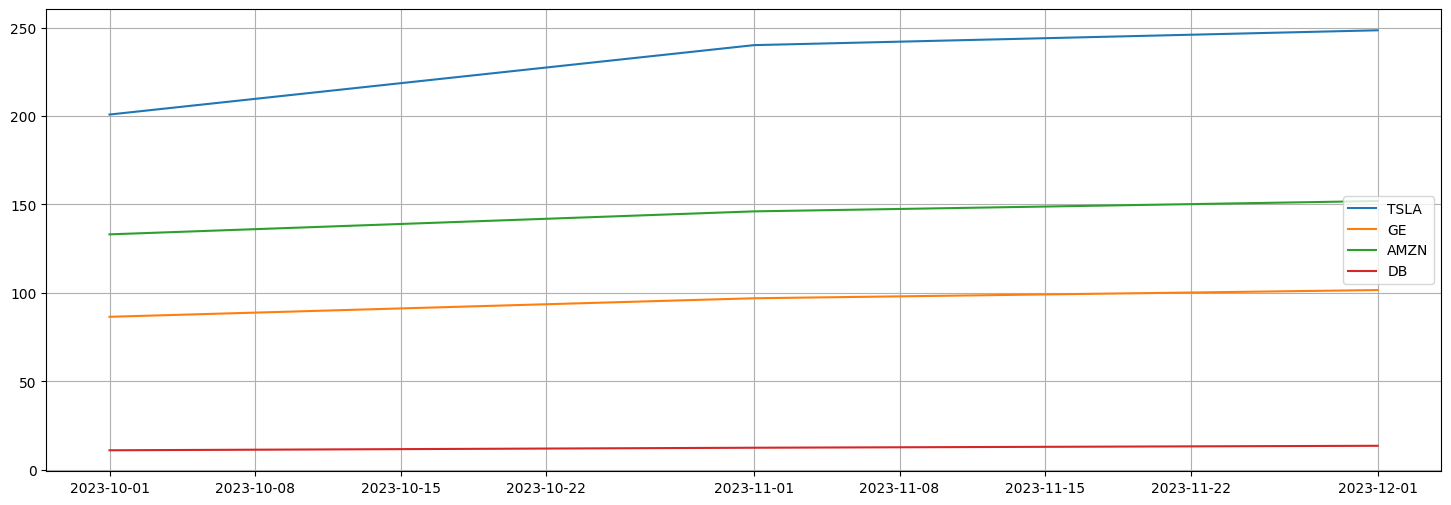

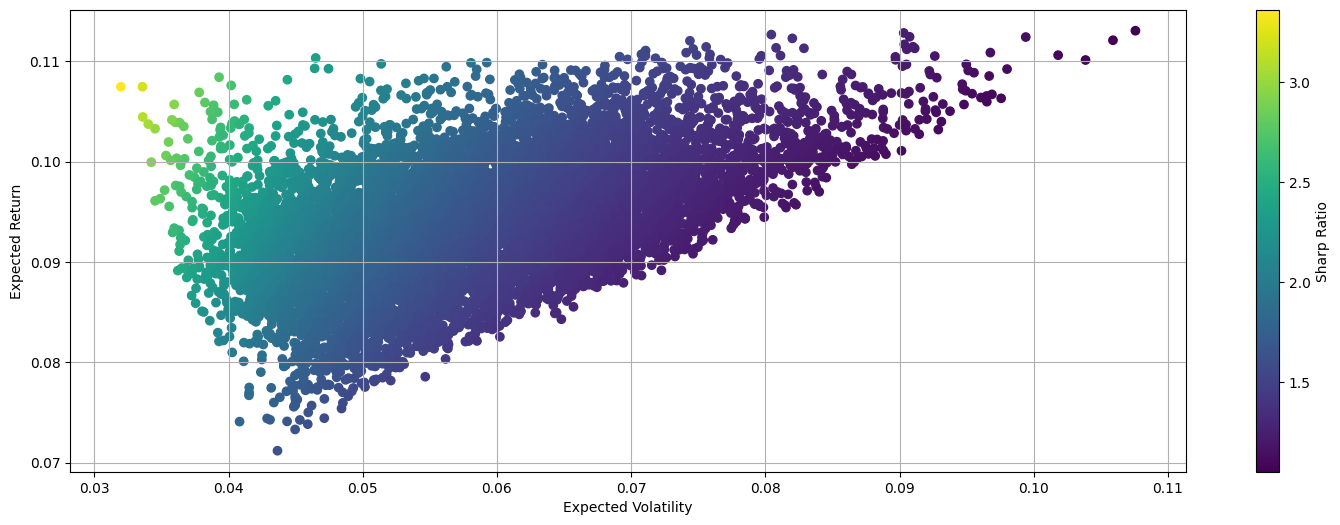

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [0.06886106 0.04075369 1.68968913]


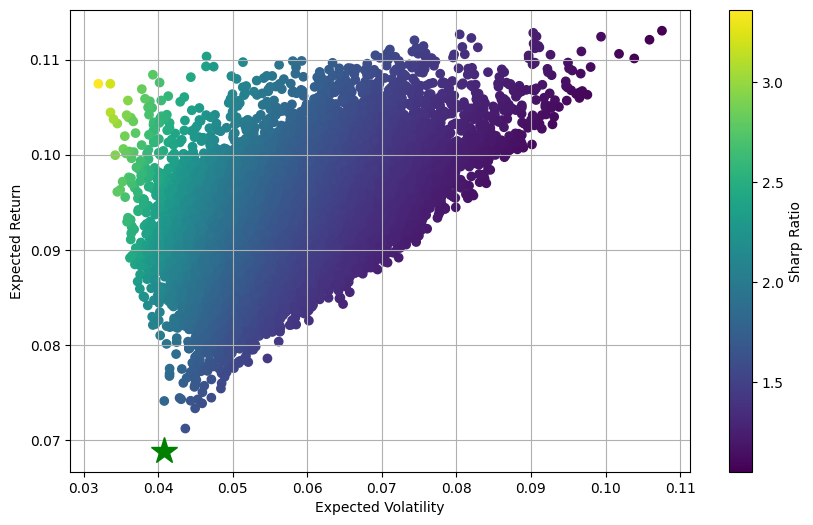

-----------------------------------------------------
------------------- Final results -------------------
Selected stock: ['TSLA', 'GE', 'AMZN', 'DB']
Weights: [0. 0. 1. 0.]
Returns: [0.         0.         0.09767827 0.        ]
-----------------------------------------------------


In [23]:
# print(returns)
_, _, returns = portfolio(stocks, df, 4, 2)
returns = np.array(returns[1:])
# print(returns)

In [24]:
# генерируем массив дат с шагом в месяц
start_month = 1
start_year = 2014
end_month = 1
end_year = 2024
curr_month = start_month
curr_year = start_year

start_datetime = datetime.datetime(start_year, start_month, 1)
curr_datetime = datetime.datetime(start_year, start_month, 1)
end_datetime = datetime.datetime(end_year, end_month, 1)

dates = []
while curr_datetime < end_datetime:
    dates.append(curr_datetime.strftime("%Y-%m-%d")) 
    curr_datetime += relativedelta(months=1)
dates.append(end_datetime.strftime("%Y-%m-%d"))
print(dates)

['2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01', '2019

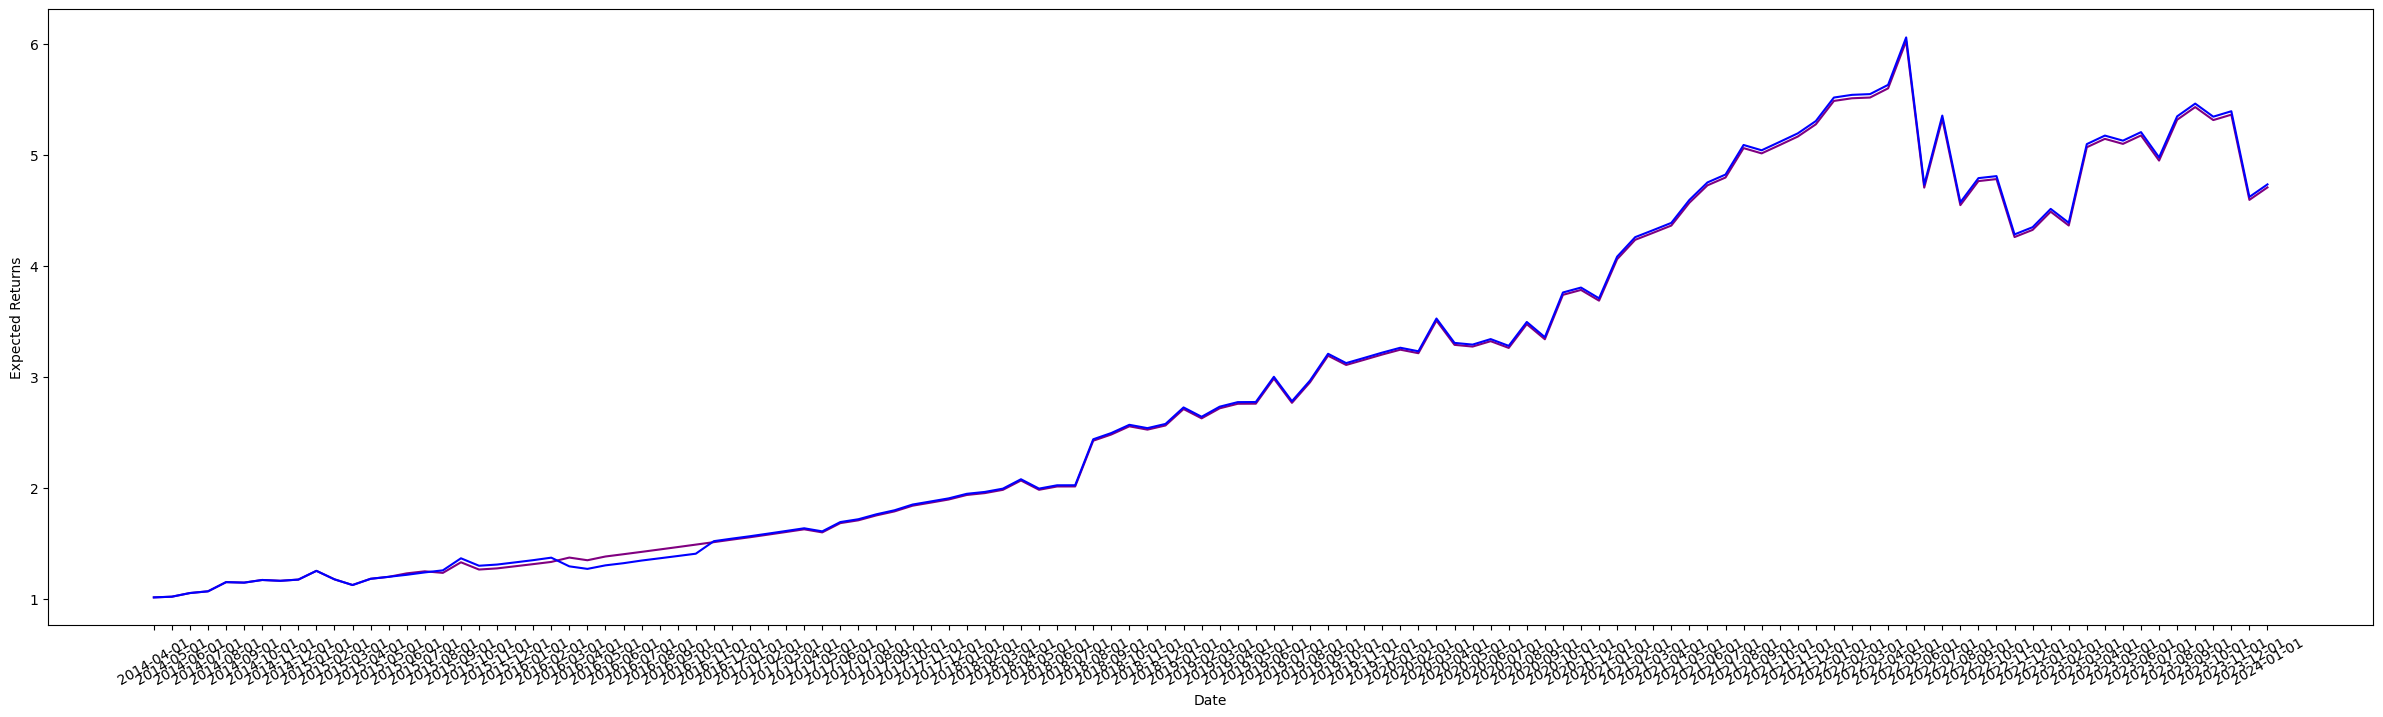

In [25]:
# Рисуем график для нашей стратегии с ребалансировкой
# print(len(returns))
# print(len(dates))

plt.figure(figsize = (30,8))
plt.xlabel('Date')
plt.ylabel('Expected Returns')
plt.xticks(rotation=30)
plt.plot(
    dates[3:],
    (1 + not_rebalance_returns).cumprod(), color:='purple'
    # markersize = 20
)
plt.plot(
    dates[3:],
    (1 + returns).cumprod(), color:='blue'
    # markersize = 20
)
plt.show()

In [26]:
# Рисуем график для общепринятого индекса S&P500

sp500 = yf.download("^GSPC", start = start_datetime, end = end_datetime, interval='1mo')
# print(sp500)
close = sp500["Close"]
sp500["monthly_returns"] = sp500["Adj Close"].pct_change().fillna(0)
# print(len(sp500["monthly_returns"]))
# plt.plot((1+sp500["monthly_returns"].reset_index(drop=True)).cumprod())
# plt.title("S&P500 Index Return vs Rebalancing Strategy Return")
# plt.ylabel("cumulative return")
# plt.xlabel("months")
# plt.legend("Index Return")

[*********************100%%**********************]  1 of 1 completed


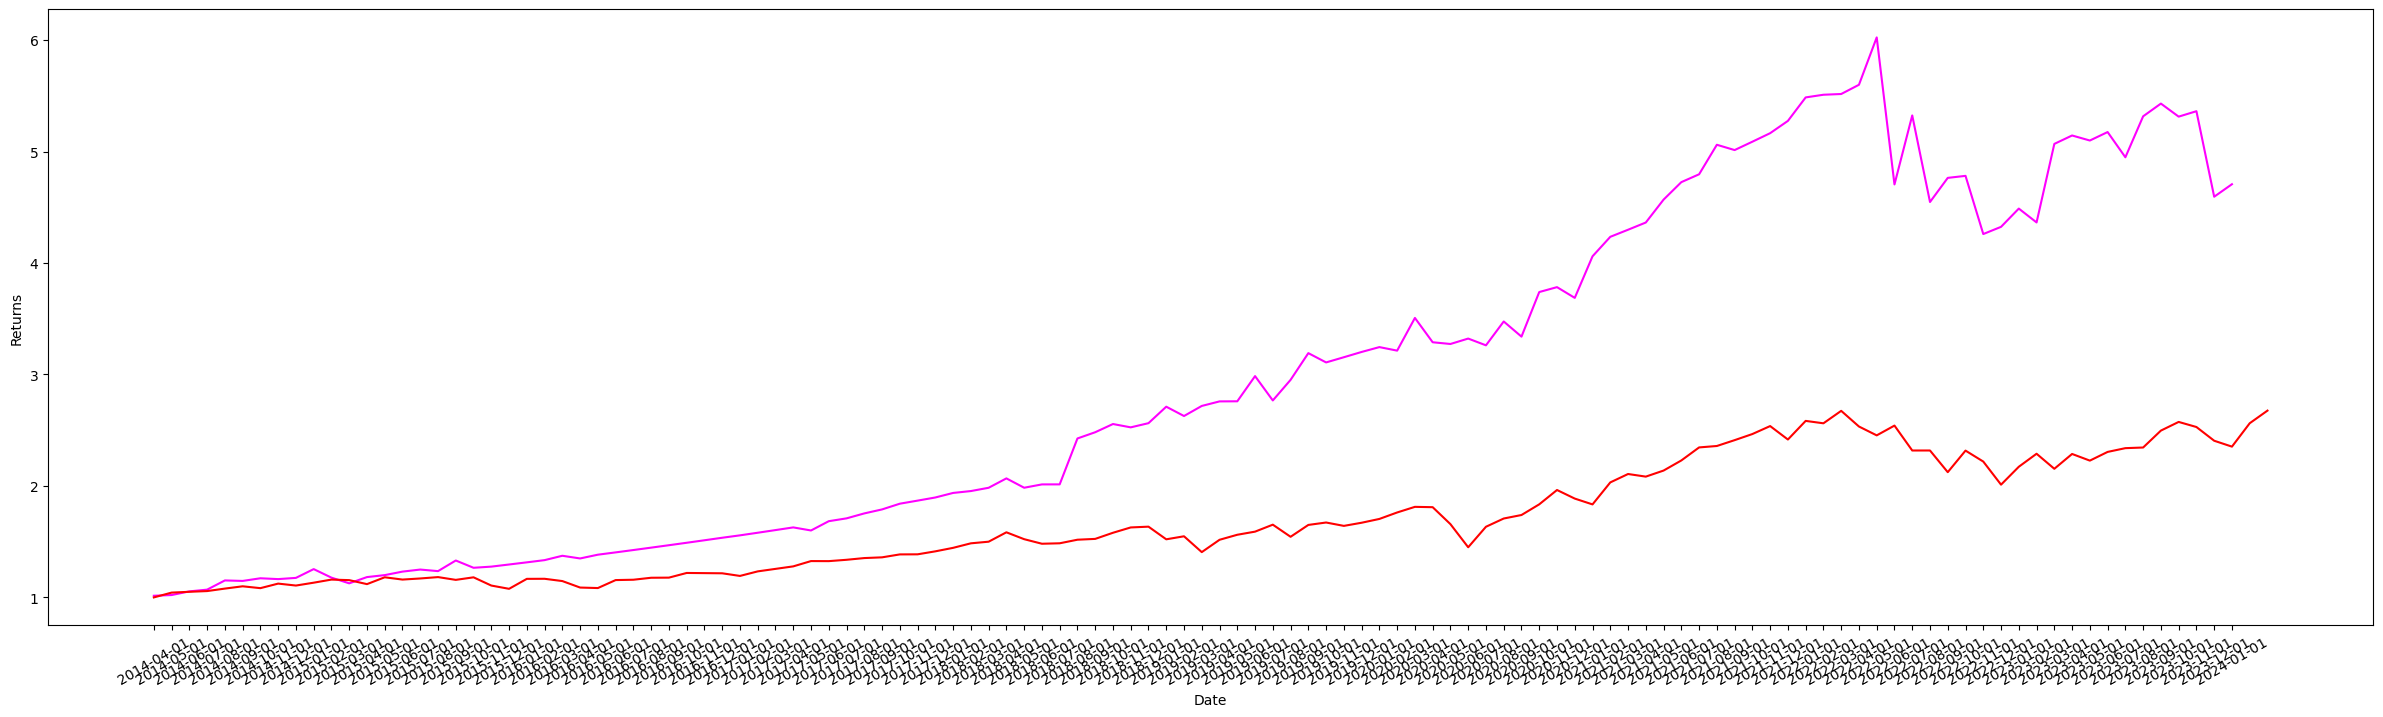

In [27]:
# Сравнение индекса и алгоритма без балансировки, бэктестинг

plt.figure(figsize = (30,8))
plt.xlabel('Date')
plt.ylabel('Returns')
plt.xticks(rotation=30)
plt.plot(
    dates[3:],
    (1 + not_rebalance_returns).cumprod(),
    color:='magenta'
)
plt.plot((1+sp500["monthly_returns"].reset_index(drop=True)).cumprod(), color:='red')
plt.show()

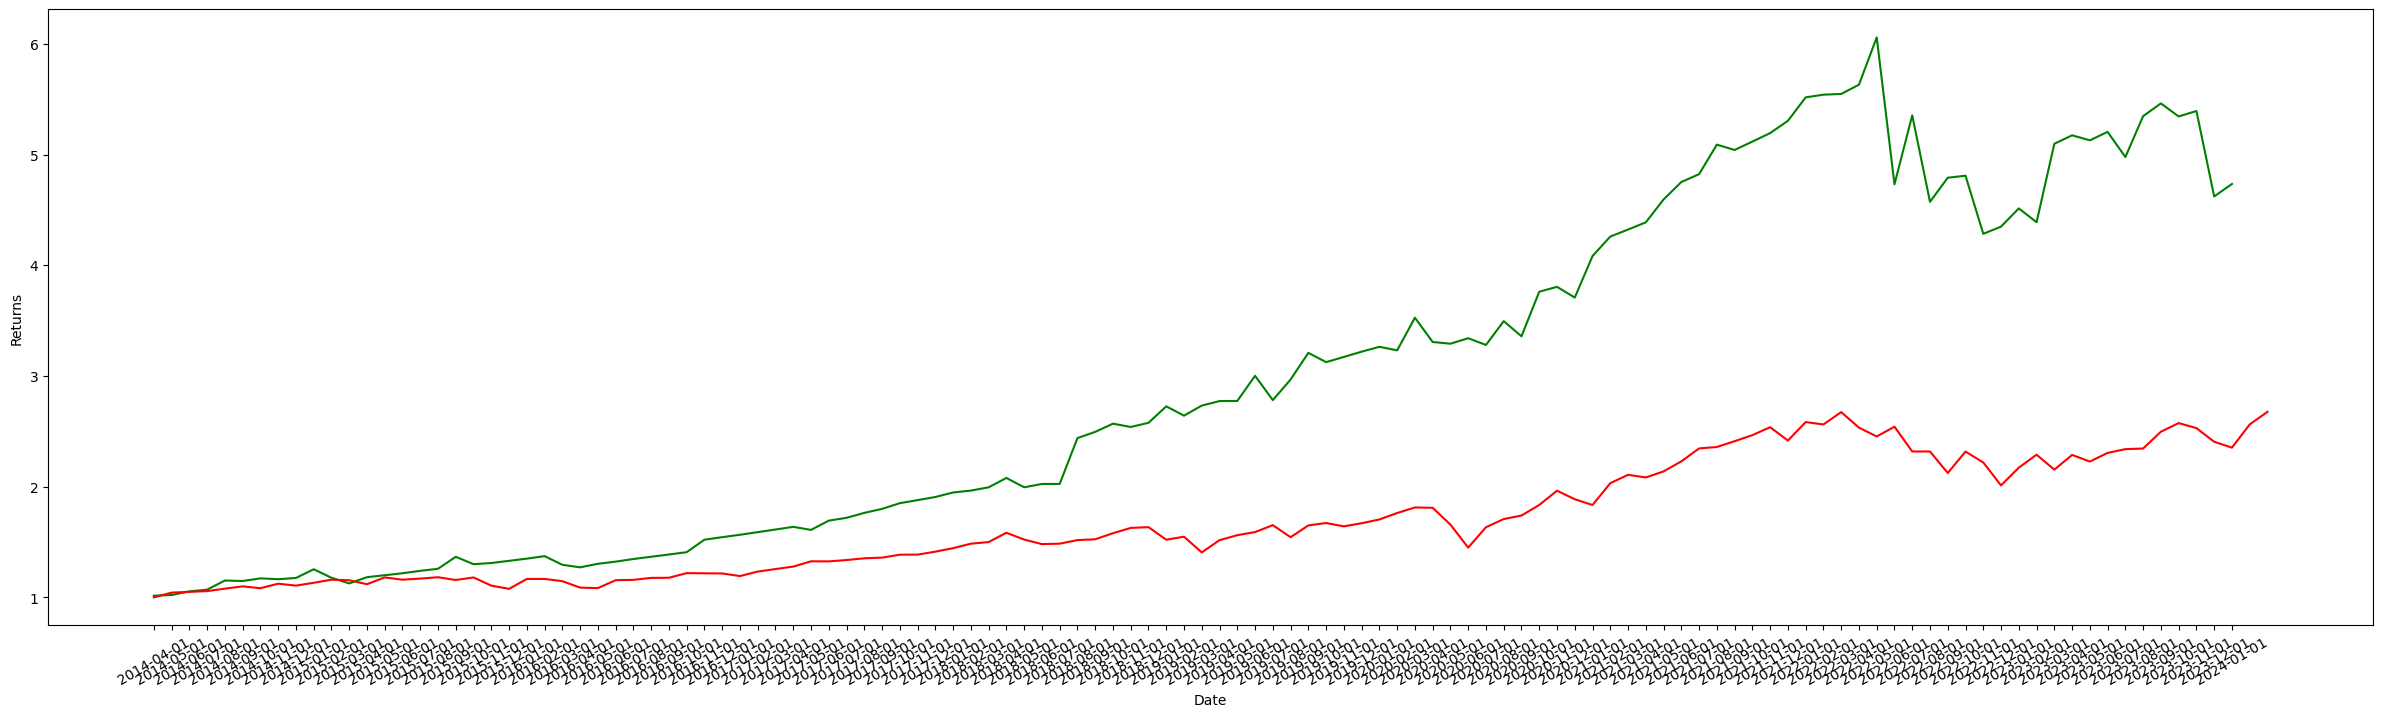

In [34]:
# Сравнение индекса и нашего алгоритма с ребалансировкой, бэктестинг

plt.figure(figsize = (30,8))
plt.xlabel('Date')
plt.ylabel('Returns')
plt.xticks(rotation=30)
plt.plot(
    dates[3:],
    (1 + returns).cumprod(),
    color='green',
    label="rebalanced Markowitz"
)
plt.plot((1+sp500["monthly_returns"].reset_index(drop=True)).cumprod(), color='red', label='index')
plt.show()

## Видим, что нам не удалось перепрыгнуть S&P500, но это норм, мало кому удается его обогнать (вроде бы)